# SIF Analysis: Tariffs & Crop Shifts in the Corn Belt

This notebook analyzes Solar-Induced Chlorophyll Fluorescence (SIF) data from OCO-2/OCO-3 satellites to investigate how U.S. trade tariffs, input costs, and management changes since 2020 have influenced vegetation productivity across the U.S. Corn Belt.

**Dataset**: Harmonized, gap-filled global SIF product (2014-2024) by Jiaming Wen et al.

**Goals**:
- Visualize SIF changes over time (2014-2024) 
- Create US-focused animation showing temporal patterns
- Later: Overlay with USDA Cropland Data Layer for crop-specific analysis


In [1]:
# Test paths and verify we can find the data
from pathlib import Path
import os

print("Current working directory:", os.getcwd())
print()

# Test the data directory path
data_dir = Path("../data/raw/SIF_OCO2_005_v11r")
print(f"Looking for data in: {data_dir}")
print(f"Data directory exists: {data_dir.exists()}")
print(f"Absolute path: {data_dir.absolute()}")

if data_dir.exists():
    nc4_files = list(data_dir.glob("*.nc4"))
    print(f"Found {len(nc4_files)} .nc4 files")
    if nc4_files:
        print(f"First file: {nc4_files[0].name}")
        print("✓ Data directory and files found!")
    else:
        print("⚠ Data directory exists but no .nc4 files found")
else:
    print("❌ Data directory not found - check the path")

print()
print("If this works, you can proceed to run the other cells in order.")


Current working directory: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/src

Looking for data in: ../data/raw/SIF_OCO2_005_v11r
Data directory exists: True
Absolute path: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/src/../data/raw/SIF_OCO2_005_v11r
Found 251 .nc4 files
First file: sif_ann_201503a.nc4
✓ Data directory and files found!

If this works, you can proceed to run the other cells in order.


## 1. Environment Setup & SIF Data Catalog

**Purpose:** Initialize the analysis environment, verify data availability, and explore the dataset structure to ensure reproducibility.

**What happens:**
- **Path verification:** Confirms that the data directory exists and that NetCDF (.nc4) SIF files are accessible
- **Library imports:** Loads essential Python packages (xarray, rioxarray, numpy, matplotlib, pandas, etc.)
- **Dataset exploration:** Opens a sample SIF file to inspect dimensions, coordinates, and structure
- **Temporal inventory:** Catalogs all 251 SIF files spanning 2014-2024, extracting metadata about:
    - Year/month information from filenames
    - Half-month designations ('a' = first half days 1-15, 'b' = second half days 16-end)
    - Data coverage (12 years × 12 months × 2 half-months)

**Key outputs:**
- Confirmation of 251 .nc4 files found
- Dataset dimensions: 3600×7200 (latitude × longitude)
- Coverage: September 2014 through late 2024
- File naming convention understood: `sif_ann_YYYYMMa/b.nc4`

**Reproducibility notes:**
- Absolute paths are used for data directories
- Console output confirms successful data discovery
- Sets plotting style parameters for consistent visualization


In [2]:
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import imageio
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

ds = xr.open_dataset("../data/raw/SIF_OCO2_005_v11r/sif_ann_201409a.nc4")
print(ds.dims)
print(ds.coords)


FrozenMappingWarningOnValuesAccess({'latitude': 3600, 'longitude': 7200})
Coordinates:
  * longitude  (longitude) float64 58kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * latitude   (latitude) float64 29kB -89.97 -89.92 -89.88 ... 89.92 89.97


In [3]:
# Define paths
data_dir = Path("../data/raw/SIF_OCO2_005_v11r")
figures_dir = Path("../figures")

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Figures directory: {figures_dir}")


Data directory: ../data/raw/SIF_OCO2_005_v11r
Figures directory: ../figures


In [4]:
# List all .nc4 files and extract temporal information
nc4_files = sorted(data_dir.glob("*.nc4"))
print(f"Found {len(nc4_files)} .nc4 files")

# Extract detailed information from filenames
# Format: sif_ann_yyyymm"a"or"b".nc4 (e.g., sif_ann_201401a.nc4, sif_ann_201401b.nc4)
# where 'a' = first half of month (days 1-15), 'b' = second half of month (days 16-end)

file_info = []
for file in nc4_files:
    filename = file.name
    if 'sif_ann_' in filename:
        # Extract the part after 'sif_ann_' and before '.nc4'
        year_month_part = filename.split('sif_ann_')[1].split('.nc4')[0]
        
        if year_month_part.endswith('a') or year_month_part.endswith('b'):
            # Extract all components
            half = year_month_part[-1]  # 'a' = first half of month (days 1-15), 'b' = second half (days 16-end)
            year_month = year_month_part[:-1]  # Remove 'a' or 'b'
            year = year_month[:4]  # Extract year (e.g., '2014')
            month = year_month[4:]  # Extract month (e.g., '01')
            
            # Store detailed info
            file_info.append({
                'filename': filename,
                'year': year,
                'month': month,
                'half': half,
                'half_description': 'first half (days 1-15)' if half == 'a' else 'second half (days 16-end)',
                'year_month': year_month,
                'file_path': file,
                'sort_key': f"{year}{month}{half}"  # For proper chronological sorting
            })

# Sort by chronological order
file_info = sorted(file_info, key=lambda x: x['sort_key'])

# Create summary
years = sorted(list(set([info['year'] for info in file_info])))
months = sorted(list(set([info['month'] for info in file_info])))

print(f"\n📊 Dataset Summary:")
print(f"  Total files: {len(file_info)}")
print(f"  Years: {years} ({len(years)} years)")
print(f"  Months: {months} ({len(months)} months)")
print(f"  Year range: {min(years)} - {max(years)}")
print(f"  Temporal resolution: Half-monthly (2 observations per month)")

# Show first few files in chronological order
print(f"\n📁 First 5 files (chronological order):")
for i, info in enumerate(file_info[:5]):
    print(f"  {info['filename']} → {info['year']}-{info['month']} ({info['half_description']})")


Found 251 .nc4 files

📊 Dataset Summary:
  Total files: 251
  Years: ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025'] (12 years)
  Months: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'] (12 months)
  Year range: 2014 - 2025
  Temporal resolution: Half-monthly (2 observations per month)

📁 First 5 files (chronological order):
  sif_ann_201409a.nc4 → 2014-09 (first half (days 1-15))
  sif_ann_201409b.nc4 → 2014-09 (second half (days 16-end))
  sif_ann_201410a.nc4 → 2014-10 (first half (days 1-15))
  sif_ann_201410b.nc4 → 2014-10 (second half (days 16-end))
  sif_ann_201411a.nc4 → 2014-11 (first half (days 1-15))


## 2. Data Preprocessing: Agricultural Masks

**Purpose:** Prepare agricultural land masks to isolate cropland pixels in SIF analysis, focusing on Iowa's corn/soy belt.

**Process:**
- **i. Setup:** Load Iowa county boundaries (GeoJSON) and dissolve to create accurate state boundary for spatial clipping
- **ii. Load CDL Data:** Import USDA Cropland Data Layer (CDL) rasters for 2014-2024 (11 annual files at ~30m resolution)
- **iii. Resize CDL:** Create fast mode-resampling functions to downscale high-resolution CDL to match SIF resolution while preserving categorical crop codes
- **iv. Process & Mask:** For each year:
  - Clip CDL to Iowa boundary using county-based shapefile (accurate boundary, not rectangular bbox)
  - Downscale using block-mode resampling (preserves dominant land cover)
  - Generate binary agricultural masks (1=cropland, 0=non-ag)
  - Includes field crops, specialty crops, hay, orchards (~61-62% of pixels)

**Key outputs:**
- `iowa_counties`: GeoDataFrame with 99 Iowa county boundaries (enables future county-level analysis)
- `iowa_shape`: Dissolved state boundary from counties (used for clipping)
- `ag_masks`: Dictionary of 11 annual binary masks (2014-2024) clipped to Iowa
- `cdl_clipped`: Downscaled CDL arrays for each year

**Note:** Masks exclude forest, developed land, water, pasture, and wetlands to focus analysis on actively managed agricultural areas.

#### i. Set up

In [5]:
# Create agricultural masks for each year (2014-2024)
ag_masks = {}
for year in range(2014, 2025):
    cdl_path = f'/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/Cornbelt_annual_CDL/Cornbelt_annual_CDL_cropland_{year}-01.tif'
    cdl_data = rioxarray.open_rasterio(cdl_path, masked=True)
    
    # Create mask for agricultural land (corn=1, soy=5)
    ag_mask_year = xr.where((cdl_data == 1) | (cdl_data == 5), 1, 0)
    ag_masks[year] = ag_mask_year
    
print(f"Created agricultural masks for years {list(ag_masks.keys())}")


Created agricultural masks for years [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [6]:
# Load Iowa county boundaries for accurate clipping
import geopandas as gpd
from pathlib import Path

print("=" * 60)
print("LOADING IOWA COUNTY BOUNDARIES")
print("=" * 60)

# Load Iowa county boundaries from local file
county_file = Path("../data/raw/Iowa_County_Boundaries.geojson")
print(f"Loading from: {county_file}")

if not county_file.exists():
    print(f"❌ ERROR: County file not found at {county_file.absolute()}")
    print("Please check the file path and name")
else:
    iowa_counties = gpd.read_file(county_file)
    print(f"✓ Loaded {len(iowa_counties)} Iowa counties")
    print(f"  Original CRS: {iowa_counties.crs}")
    
    # Ensure it's in EPSG:4326 (lat/lon) to match SIF data
    if iowa_counties.crs != 'EPSG:4326':
        print(f"  Reprojecting to EPSG:4326...")
        iowa_counties = iowa_counties.to_crs('EPSG:4326')
    
    # Create dissolved state boundary from counties (for overall clipping)
    iowa_shape = iowa_counties.geometry.union_all()  # Dissolves all counties into single boundary
    
    print(f"✓ Iowa boundaries loaded successfully!")
    print(f"  CRS: {iowa_counties.crs}")
    print(f"  Counties: {len(iowa_counties)}")
    print(f"  State bounds (lon/lat): {iowa_shape.bounds}")
    print(f"    minx={iowa_shape.bounds[0]:.3f}, miny={iowa_shape.bounds[1]:.3f}")
    print(f"    maxx={iowa_shape.bounds[2]:.3f}, maxy={iowa_shape.bounds[3]:.3f}")
    
    # Show sample county names
    if 'COUNTYNAME' in iowa_counties.columns:
        print(f"\n  Sample counties: {', '.join(iowa_counties['COUNTYNAME'].head(5).tolist())}")
    elif 'NAME' in iowa_counties.columns:
        print(f"\n  Sample counties: {', '.join(iowa_counties['NAME'].head(5).tolist())}")
    elif 'NAMELSAD' in iowa_counties.columns:
        print(f"\n  Sample counties: {', '.join(iowa_counties['NAMELSAD'].head(5).tolist())}")
    
    print()
    print("County boundaries available for future county-level analysis")
    print("Dissolved state boundary will be used for initial clipping")
    print("=" * 60)


LOADING IOWA COUNTY BOUNDARIES
Loading from: ../data/raw/Iowa_County_Boundaries.geojson
✓ Loaded 99 Iowa counties
  Original CRS: EPSG:4326
✓ Iowa boundaries loaded successfully!
  CRS: EPSG:4326
  Counties: 99
  State bounds (lon/lat): (-96.6394933879999, 40.37544738, -90.1400674939999, 43.501203639)
    minx=-96.639, miny=40.375
    maxx=-90.140, maxy=43.501

  Sample counties: Jasper, Plymouth, Pottawattamie, Wapello, Buchanan

County boundaries available for future county-level analysis
Dissolved state boundary will be used for initial clipping


In [7]:
# Load libraries
from pathlib import Path
import re, numpy as np, pandas as pd, xarray as xr

# Create path to SIF data
SIF_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/SIF_OCO2_005_v11r")

# Where to save quick CSV outputs 
OUT_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Setup complete - Iowa county boundaries loaded in previous cell")


✓ Setup complete - Iowa county boundaries loaded in previous cell


#### ii. Load in CDL Data

In [8]:
# Load CDL rasters for 2014-2024 and check CRS compatibility
import rasterio

# Define CDL directory
CDL_DIR = Path("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/data/raw/Cornbelt_annual_CDL")

# Find all CDL files
CDL_FILES = list(CDL_DIR.glob("*.tif"))
print(f"Found {len(CDL_FILES)} CDL files")

# Filter for years 2014-2024 and create a dictionary
cdl_files_by_year = {}
for file in CDL_FILES:
    # Extract year from filename (e.g., "Cornbelt_annual_CDL_cropland_2010-01.tif" -> "2010")
    year = int(file.stem.split('_')[-1].split('-')[0])
    if 2014 <= year <= 2024:
        cdl_files_by_year[year] = file
        print(f"  - {file.name} (Year: {year})")

print(f"\nCDL files for 2014-2024: {len(cdl_files_by_year)} files")
print(f"Years available: {sorted(cdl_files_by_year.keys())}")

# Check CDL file properties
print(f"\nChecking CDL file properties...")

# Load a sample CDL file to check its properties
sample_cdl_file = list(cdl_files_by_year.values())[0]
print(f"Sample CDL file: {sample_cdl_file.name}")

with rasterio.open(sample_cdl_file) as cdl_ds:
    cdl_crs = cdl_ds.crs
    print(f"CDL CRS: {cdl_crs}")
    
    # Show other properties
    print(f"CDL shape: {cdl_ds.shape}")
    print(f"CDL bounds: {cdl_ds.bounds}")
    print(f"CDL bands: {cdl_ds.count}")
    print(f"Band names: {cdl_ds.descriptions}")

print("✓ CDL loading complete!")
print("Note: CRS compatibility with SIF data will be checked later when file_info is available.")


Found 15 CDL files
  - Cornbelt_annual_CDL_cropland_2022-01.tif (Year: 2022)
  - Cornbelt_annual_CDL_cropland_2018-01.tif (Year: 2018)
  - Cornbelt_annual_CDL_cropland_2014-01.tif (Year: 2014)
  - Cornbelt_annual_CDL_cropland_2020-01.tif (Year: 2020)
  - Cornbelt_annual_CDL_cropland_2016-01.tif (Year: 2016)
  - Cornbelt_annual_CDL_cropland_2024-01.tif (Year: 2024)
  - Cornbelt_annual_CDL_cropland_2019-01.tif (Year: 2019)
  - Cornbelt_annual_CDL_cropland_2015-01.tif (Year: 2015)
  - Cornbelt_annual_CDL_cropland_2023-01.tif (Year: 2023)
  - Cornbelt_annual_CDL_cropland_2017-01.tif (Year: 2017)
  - Cornbelt_annual_CDL_cropland_2021-01.tif (Year: 2021)

CDL files for 2014-2024: 11 files
Years available: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Checking CDL file properties...
Sample CDL file: Cornbelt_annual_CDL_cropland_2022-01.tif
CDL CRS: EPSG:4326
CDL shape: (697, 1448)
CDL bounds: BoundingBox(left=-96.64075826557813, bottom=40.3747804447519, right=-90.1369556

#### iii. Resize the CDL to match SIF

In [9]:
# FAST downscale CDL data using block-based mode resampling
from scipy.stats import mode
import numpy as np

def downscale_cdl_mode_fast(cdl_array, target_shape):
    """
    Fast downscale of CDL data using block-based mode resampling for categorical data.
    This is MUCH faster than generic_filter approach.
    
    Parameters:
    -----------
    cdl_array : numpy.ndarray
        Input CDL array to downscale (2D)
    target_shape : tuple
        Target (height, width) for the output array
    
    Returns:
    --------
    numpy.ndarray
        Downscaled CDL array using mode resampling
    """
    input_height, input_width = cdl_array.shape
    target_height, target_width = target_shape
    
    # Calculate block sizes
    block_height = input_height // target_height
    block_width = input_width // target_width
    
    # Trim the array to be evenly divisible by blocks
    trimmed_height = target_height * block_height
    trimmed_width = target_width * block_width
    cdl_trimmed = cdl_array[:trimmed_height, :trimmed_width]
    
    # Reshape into blocks and compute mode
    # Reshape to (target_height, block_height, target_width, block_width)
    blocks = cdl_trimmed.reshape(
        target_height, block_height,
        target_width, block_width
    )
    
    # Move block dimensions together: (target_height, target_width, block_height, block_width)
    blocks = blocks.transpose(0, 2, 1, 3)
    
    # Flatten the block dimensions: (target_height, target_width, block_height*block_width)
    blocks = blocks.reshape(target_height, target_width, -1)
    
    # Compute mode for each block (much faster than generic_filter!)
    downscaled = np.empty((target_height, target_width), dtype=cdl_array.dtype)
    
    for i in range(target_height):
        for j in range(target_width):
            block_values = blocks[i, j, :]
            # Remove NaN values if any
            valid_values = block_values[~np.isnan(block_values)] if block_values.dtype == float else block_values
            if len(valid_values) > 0:
                downscaled[i, j] = mode(valid_values, keepdims=False)[0]
            else:
                downscaled[i, j] = 0  # or np.nan
    
    return downscaled

# Alternative: EVEN FASTER version using numpy bincount (for integer data)
def downscale_cdl_mode_fastest(cdl_array, target_shape):
    """
    Fastest downscale using bincount for mode calculation.
    Only works with integer categorical data (which CDL is).
    
    Parameters:
    -----------
    cdl_array : numpy.ndarray
        Input CDL array to downscale (2D, integer dtype)
    target_shape : tuple
        Target (height, width) for the output array
    
    Returns:
    --------
    numpy.ndarray
        Downscaled CDL array using mode resampling
    """
    input_height, input_width = cdl_array.shape
    target_height, target_width = target_shape
    
    # Calculate block sizes
    block_height = input_height // target_height
    block_width = input_width // target_width
    
    # Trim the array to be evenly divisible by blocks
    trimmed_height = target_height * block_height
    trimmed_width = target_width * block_width
    cdl_trimmed = cdl_array[:trimmed_height, :trimmed_width].astype(int)
    
    # Reshape into blocks
    blocks = cdl_trimmed.reshape(
        target_height, block_height,
        target_width, block_width
    ).transpose(0, 2, 1, 3).reshape(target_height, target_width, -1)
    
    # Compute mode using bincount (fastest method for integers)
    downscaled = np.empty((target_height, target_width), dtype=cdl_array.dtype)
    
    for i in range(target_height):
        for j in range(target_width):
            block_values = blocks[i, j, :]
            
            # Filter out negative values (NoData/masked values)
            valid_values = block_values[block_values >= 0]
            
            if len(valid_values) > 0:
                # Use bincount to find mode (fastest for integers)
                counts = np.bincount(valid_values)
                downscaled[i, j] = np.argmax(counts)
            else:
                # If no valid values, set to 0 or a NoData value
                downscaled[i, j] = 0
    
    return downscaled

print("✓ Fast CDL downscaling functions loaded!")
print("  - downscale_cdl_mode_fast: Works with any data")
print("  - downscale_cdl_mode_fastest: Fastest for integer categorical data (recommended for CDL)")


✓ Fast CDL downscaling functions loaded!
  - downscale_cdl_mode_fast: Works with any data
  - downscale_cdl_mode_fastest: Fastest for integer categorical data (recommended for CDL)


#### iv. Clip CDL, Downscale and Identify Ag

In [10]:
# Clip CDL data to Iowa using county shapefile and create agricultural masks

# Dictionary to store agricultural masks for each year
ag_masks = {}
cdl_clipped = {}

print("=" * 60)
print("PROCESSING CDL DATA WITH IOWA SHAPEFILE")
print("=" * 60)
print(f"Processing CDL data for years 2014-2024...")
print(f"Clipping method: Iowa county boundary shapefile (accurate)")
print()

for year in sorted(cdl_files_by_year.keys()):
    cdl_file = cdl_files_by_year[year]
    print(f"Processing year {year}...")
    
    # Step 1: Load CDL data using rioxarray
    cdl_data = rioxarray.open_rasterio(cdl_file, masked=True)
    print(f"  Original CDL shape: {cdl_data.shape}")
    
    # Step 2: Clip to Iowa state boundary using shapefile
    print(f"  Clipping to Iowa shapefile boundary...")
    # rioxarray.clip() expects a list of geometries
    cdl_iowa = cdl_data.rio.clip([iowa_shape], crs="EPSG:4326", drop=True)
    print(f"  Iowa-clipped CDL shape: {cdl_iowa.shape}")
    
    # Step 3: Extract 2D array (first band) - keep at native resolution
    # We'll resize the mask dynamically to match SIF resolution during processing
    cdl_array = cdl_iowa.values[0, :, :]  # Remove band dimension
    print(f"  CDL array shape (native resolution): {cdl_array.shape}")
    
    # Note: Mask will be resized to match SIF resolution dynamically
    cdl_downscaled = cdl_array  # Keep at native resolution for now
    
    # Step 4: Create agricultural mask for ALL cropland
    # CDL codes: 1-61 are typical cropland, plus some tree crops up to ~250
    # Exclude non-ag: 0 (background), 63-65 (forest), 81-88 (developed/water/wetlands), 111+ (water, developed, forest, grass/pasture, wetlands)
    # See: https://www.nass.usda.gov/Research_and_Science/Cropland/docs/cdl_codes_names.csv
    
    # Create mask for all agricultural/cropland pixels
    # Include: 1-61 (all crops), 66-77 (orchards/tree crops), 204-254 (specific crops)
    # Exclude: 0 (background), 60 (fallow), 63-65 (forest), 81+ (non-ag)
    ag_mask = np.where(
        ((cdl_downscaled >= 1) & (cdl_downscaled <= 59)) |  # All crops (excluding fallow/idle at 61)
        ((cdl_downscaled >= 66) & (cdl_downscaled <= 77)) |  # Tree crops/orchards
        ((cdl_downscaled >= 204) & (cdl_downscaled <= 254)), # Other specific crops
        1, 0
    )
    
    # Report unique crop types found
    unique_crops = np.unique(cdl_downscaled[cdl_downscaled > 0])
    print(f"  Unique crop codes found: {unique_crops[:20]}...")  # Show first 20
    
    # Calculate statistics
    total_pixels = ag_mask.size
    ag_pixels = np.sum(ag_mask)
    ag_percentage = (ag_pixels / total_pixels) * 100
    
    print(f"  Agricultural pixels: {ag_pixels}/{total_pixels} ({ag_percentage:.1f}%)")
    
    # Store in dictionaries
    cdl_clipped[year] = cdl_downscaled
    ag_masks[year] = ag_mask
    print(f"  ✓ Year {year} complete\n")

print("="*60)
print(f"CDL processing complete!")
print(f"Years processed: {sorted(ag_masks.keys())}")
print(f"Masks created at native CDL resolution (will be resized to match SIF during processing)")
print(f"Total ag masks created: {len(ag_masks)}")
print()
print("Agricultural mask includes ALL cropland:")
print("  - Field crops: corn, soy, wheat, oats, barley, etc.")
print("  - Specialty crops: vegetables, melons, etc.")
print("  - Hay and forage crops: alfalfa, other hay")
print("  - Tree crops: orchards, vineyards, etc.")
print("  - Excludes: forest, developed land, water, grassland/pasture, wetlands")
print("="*60)


PROCESSING CDL DATA WITH IOWA SHAPEFILE
Processing CDL data for years 2014-2024...
Clipping method: Iowa county boundary shapefile (accurate)

Processing year 2014...
  Original CDL shape: (1, 697, 1448)
  Clipping to Iowa shapefile boundary...
  Iowa-clipped CDL shape: (1, 696, 1447)
  CDL array shape (native resolution): (696, 1447)
  Unique crop codes found: [ 1.  4.  5. 12. 13. 21. 22. 23. 24. 26. 27. 28. 36. 37. 42. 43. 44. 53.
 58. 59.]...
  Agricultural pixels: 546963/1007112 (54.3%)
  ✓ Year 2014 complete

Processing year 2015...
  Original CDL shape: (1, 697, 1448)
  Clipping to Iowa shapefile boundary...
  Iowa-clipped CDL shape: (1, 696, 1447)
  CDL array shape (native resolution): (696, 1447)
  Unique crop codes found: [ 1.  4.  5. 12. 13. 21. 23. 24. 26. 27. 28. 29. 36. 37. 39. 42. 43. 53.
 58. 59.]...
  Agricultural pixels: 526244/1007112 (52.3%)
  ✓ Year 2015 complete

Processing year 2016...
  Original CDL shape: (1, 697, 1448)
  Clipping to Iowa shapefile boundary...
 

#### v. Prepare ag masks for use with SIF

In [11]:
# The masks are already at the correct resolution (62, 130) matching Iowa SIF data

print("Agricultural Masks Ready for SIF Processing")
print("=" * 60)
print(f"Years with ag masks: {sorted(ag_masks.keys())}")
print(f"Mask shape: {list(ag_masks.values())[0].shape}")
print()

# Display statistics for each year
for year in sorted(ag_masks.keys()):
    mask = ag_masks[year]
    total = mask.size
    ag_pixels = np.sum(mask)
    ag_pct = (ag_pixels / total) * 100
    print(f"  {year}: {ag_pixels:,}/{total:,} pixels ({ag_pct:.1f}%) are agricultural")

print()
print("✓ Masks are ready to be applied to SIF data!")
print("  Use ag_masks[year] when processing SIF data for each year")
print("=" * 60)


Agricultural Masks Ready for SIF Processing
Years with ag masks: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Mask shape: (696, 1447)

  2014: 546,963/1,007,112 pixels (54.3%) are agricultural
  2015: 526,244/1,007,112 pixels (52.3%) are agricultural
  2016: 530,088/1,007,112 pixels (52.6%) are agricultural
  2017: 540,625/1,007,112 pixels (53.7%) are agricultural
  2018: 542,239/1,007,112 pixels (53.8%) are agricultural
  2019: 537,352/1,007,112 pixels (53.4%) are agricultural
  2020: 547,805/1,007,112 pixels (54.4%) are agricultural
  2021: 545,962/1,007,112 pixels (54.2%) are agricultural
  2022: 538,416/1,007,112 pixels (53.5%) are agricultural
  2023: 537,369/1,007,112 pixels (53.4%) are agricultural
  2024: 554,151/1,007,112 pixels (55.0%) are agricultural

✓ Masks are ready to be applied to SIF data!
  Use ag_masks[year] when processing SIF data for each year


#### vi. Run masks over SIF data

### OPTIONAL: Load Previously Processed Data (Skip Processing)

Run this cell to load cached data instead of reprocessing (saves ~9 minutes). If no cached data exists, skip this cell and run the processing loop below.


In [ ]:
# Load previously processed data from cache
from pathlib import Path
import pandas as pd

processed_file = Path("../data/processed/iowa_sif_halfmonthly.parquet")
csv_file = Path("../data/processed/iowa_sif_halfmonthly.csv")

if processed_file.exists():
    print("⚡ Loading cached data from Parquet...")
    try:
        df = pd.read_parquet(processed_file)
        print(f"✓ Loaded {len(df)} observations instantly!")
        print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"  Skip to plotting cells below ↓")
    except ImportError as e:
        print(f"⚠ Parquet loading failed: {e}")
        print("  Installing pyarrow: pip install pyarrow")
        if csv_file.exists():
            print("  Falling back to CSV loading...")
            df = pd.read_csv(csv_file)
            print(f"✓ Loaded {len(df)} observations from CSV!")
            print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
            print(f"  Skip to plotting cells below ↓")
        else:
            print(f"❌ No cached data found. Run the processing cell below.")
    except Exception as e:
        print(f"⚠ Parquet loading failed: {e}")
        if csv_file.exists():
            print("  Falling back to CSV loading...")
            df = pd.read_csv(csv_file)
            print(f"✓ Loaded {len(df)} observations from CSV!")
            print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
            print(f"  Skip to plotting cells below ↓")
        else:
            print(f"❌ No cached data found. Run the processing cell below.")
elif csv_file.exists():
    print("⚡ Loading cached data from CSV...")
    df = pd.read_csv(csv_file)
    print(f"✓ Loaded {len(df)} observations!")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Skip to plotting cells below ↓")
else:
    print(f"❌ No cached data found at:")
    print(f"  - Parquet: {processed_file}")
    print(f"  - CSV: {csv_file}")
    print("Run the processing cell below to generate and save data.")


This code chunk uses the agricultural masks we have now built and applies them across the dataset. It computes the spatial means and standard deviation of each netCDF file (half month) and stores information into a usable dataframe for plotting and mapping. 

In [12]:

# If True, apply simple area-weighting by row using cos(latitude).
# If False, take a plain (unweighted) spatial mean/SD.
USE_AREA_WEIGHTS = "TRUE"

def open_sif_da(nc4_path: Path) -> xr.DataArray:
    
    # Open a monthly Wen SIF .nc4 file and return a 2-D DataArray with dims ('lat','lon').
    # If there's a singleton 'time' dimension, drop it (select the only slice).
    # We automatically pick the first data variable in the file as the SIF grid.
    ds = xr.open_dataset(nc4_path)

    # Pick the primary data variable
    varname = next(iter(ds.data_vars))
    da = ds[varname]  # e.g., dims like ('lat','lon') or ('time','lat','lon')

    # Standardize dimension names to 'lat'/'lon' (handles 'latitude'/'longitude', or 'y'/'x')
    dim_map = {}
    if "lat" in da.dims: dim_map["lat"] = "lat"
    elif "latitude" in da.dims: dim_map["latitude"] = "lat"
    elif "y" in da.dims: dim_map["y"] = "lat"

    if "lon" in da.dims: dim_map["lon"] = "lon"
    elif "longitude" in da.dims: dim_map["longitude"] = "lon"
    elif "x" in da.dims: dim_map["x"] = "lon"

    if dim_map:
        da = da.rename(dim_map)

    # Drop singleton time if present (monthly files sometimes carry time length 1)
    if "time" in da.dims and da.sizes["time"] == 1:
        da = da.isel(time=0)

    # At this point, da should be 2-D: ('lat','lon')
    return da

def clip_to_iowa_shape(da: xr.DataArray, iowa_geometry) -> xr.DataArray:
    """
    Clip a ('lat','lon') DataArray to Iowa state boundary using shapefile.
    
    Parameters:
    -----------
    da : xr.DataArray
        Input data array with ('lat', 'lon') dimensions
    iowa_geometry : shapely.geometry
        Iowa state boundary geometry (from geopandas)
    
    Returns:
    --------
    xr.DataArray
        Clipped data array containing only Iowa pixels
    """
    import rioxarray
    
    # Ensure the DataArray has spatial dimensions set
    if 'spatial_ref' not in da.coords:
        # Set the CRS to EPSG:4326 (lat/lon)
        da = da.rio.write_crs("EPSG:4326")
    
    # Rename dimensions to x/y for rioxarray (it expects x/y not lon/lat)
    da_renamed = da.rename({'lon': 'x', 'lat': 'y'})
    
    # Clip to Iowa geometry
    da_clipped = da_renamed.rio.clip([iowa_geometry], crs="EPSG:4326", drop=True)
    
    # Rename back to lon/lat
    da_clipped = da_clipped.rename({'x': 'lon', 'y': 'lat'})
    
    return da_clipped

def resize_mask_to_match_data(ag_mask, target_shape):
    """
    Resize agricultural mask to match SIF data dimensions.
    
    Parameters:
    - ag_mask: 2D numpy array (agricultural mask)
    - target_shape: tuple (height, width) of target dimensions
    
    Returns:
    - resized_mask: 2D numpy array with target_shape
    """
    from scipy.ndimage import zoom
    
    # Calculate zoom factors for each dimension
    zoom_factors = (target_shape[0] / ag_mask.shape[0], target_shape[1] / ag_mask.shape[1])
    
    # Use nearest neighbor interpolation to preserve binary nature of mask
    resized_mask = zoom(ag_mask.astype(float), zoom_factors, order=0) > 0.5
    
    print(f"    Resized mask from {ag_mask.shape} to {resized_mask.shape}")
    print(f"    Original agricultural pixels: {np.sum(ag_mask)}")
    print(f"    Resized agricultural pixels: {np.sum(resized_mask)}")
    
    return resized_mask

def spatial_mean_sd(da: xr.DataArray, use_weights: bool = False, ag_mask: np.ndarray = None) -> tuple[float, float]:
    """
    Compute spatial mean & SD across pixels in 'da' (ignoring NaNs).
    
    Parameters:
    - da: xarray DataArray with SIF data (2D: lat, lon)
    - use_weights: If True, weight by cos(latitude) for area weighting
    - ag_mask: Optional agricultural mask (True=agricultural, False=non-agricultural)
    
    Returns:
    - tuple: (mean, standard_deviation)
    """
    
    # Step 1: Get the raw SIF data as a numpy array
    x = da.values  # Convert xarray to numpy array for easier manipulation
    print(f"    Raw SIF data shape: {x.shape}")
    print(f"    Raw SIF data - valid pixels: {np.sum(np.isfinite(x))}")
    
    # Step 2: Apply agricultural mask if provided
    if ag_mask is not None:
        print(f"    Agricultural mask shape: {ag_mask.shape}")
        print(f"    Agricultural pixels in mask: {np.sum(ag_mask)}")
        
        # Check if mask and data have the same shape
        if ag_mask.shape != x.shape:
            print(f"    Shape mismatch detected: mask {ag_mask.shape} vs data {x.shape}")
            print(f"    Resizing mask to match data dimensions...")
            
            # Resize the mask to match the SIF data dimensions
            ag_mask = resize_mask_to_match_data(ag_mask, x.shape)
        
        # Apply the mask: set non-agricultural pixels to NaN
        # This way, only agricultural pixels will be included in statistics
        x = np.where(ag_mask, x, np.nan)  # Keep agricultural pixels, mask out non-agricultural
        print(f"    After masking - valid agricultural pixels: {np.sum(np.isfinite(x))}")
    
    # Step 3: Calculate statistics
    if not use_weights:
        # Simple mean and standard deviation (no area weighting)
        mu = float(np.nanmean(x))  # Mean of all valid (non-NaN) pixels
        sd = float(np.nanstd(x))   # Standard deviation of all valid pixels
        print(f"    Simple statistics - Mean: {mu:.4f}, SD: {sd:.4f}")
        return mu, sd

    # Step 4: Area-weighted statistics
    # This accounts for the fact that pixels near the equator represent larger areas
    print(f"    Calculating area-weighted statistics...")
    
    # Create latitude weights (cosine of latitude)
    lat_rad = np.deg2rad(da["lat"].values)  # Convert latitude to radians
    w_row = np.cos(lat_rad)                 # Weight by cos(lat) - shape (n_lat,)
    W = np.broadcast_to(w_row[:, None], da.shape)  # Expand to 2D - shape (n_lat, n_lon)

    # Find valid (non-NaN) pixels
    valid = np.isfinite(x)
    Wv = np.where(valid, W, 0.0)  # Apply weights only to valid pixels

    # Weighted mean = sum(weight * value) / sum(weight) for valid pixels
    mu = float(np.nansum(W * x) / np.sum(Wv))
    
    # Weighted standard deviation
    sd = float(np.sqrt(np.nansum(W * (x - mu)**2) / np.sum(Wv)))
    
    print(f"    Area-weighted statistics - Mean: {mu:.4f}, SD: {sd:.4f}")
    return mu, sd

# ---- Main loop over your file_info list -> builds a tidy monthly table --------
# This loop processes each SIF file and applies agricultural masking

print("=" * 60)
print("PROCESSING SIF DATA WITH AGRICULTURAL MASKING")
print("=" * 60)
print(f"Total files to process: {len(file_info)}")
print(f"Agricultural masks available for years: {sorted(ag_masks.keys())}")
print()

rows = []  # This will store our results

# Loop through each SIF file
for i, info in enumerate(file_info):
    # Extract information from the filename
    fp = info["file_path"]          # Full path to the .nc4 file
    y  = int(info["year"])          # Year (e.g., 2019)
    m  = int(info["month"])         # Month (e.g., 7)
    ab = info["half"].lower()       # Half of month: 'a' (1st half) or 'b' (2nd half)
    
    print(f"Processing file {i+1}/{len(file_info)}: {y}-{m:02d} ({ab})")
    print(f"  File: {info['filename']}")
    
    # Step 1: Load the SIF data
    print(f"  Step 1: Loading SIF data...")
    da = open_sif_da(fp)  # This creates a 2D DataArray with dimensions ('lat', 'lon')
    
    # Step 2: Clip to Iowa shapefile boundary
    print(f"  Step 2: Clipping to Iowa state boundary...")
    da_ia = clip_to_iowa_shape(da, iowa_shape)  # Clip using accurate Iowa shapefile
    print(f"    Iowa SIF data shape: {da_ia.shape}")
    
    # Step 3: Get the agricultural mask for this year
    print(f"  Step 3: Getting agricultural mask for year {y}...")
    if y in ag_masks and ag_masks[y] is not None:
        year_ag_mask = ag_masks[y]
        print(f"    Found agricultural mask for {y}")
        print(f"    Agricultural mask shape: {year_ag_mask.shape}")
        print(f"    Agricultural pixels: {np.sum(year_ag_mask)}/{year_ag_mask.size} ({100*np.sum(year_ag_mask)/year_ag_mask.size:.1f}%)")
    else:
        print(f"    WARNING: No agricultural mask found for year {y}")
        print(f"    Will process without agricultural masking")
        year_ag_mask = None
    
    # Step 4: Calculate statistics with agricultural masking
    print(f"  Step 4: Calculating statistics...")
    mu, sd = spatial_mean_sd(da_ia, USE_AREA_WEIGHTS, year_ag_mask)
    
    # Step 5: Store the results
    print(f"  Step 5: Storing results...")
    print(f"    Final SIF mean: {mu:.4f}")
    print(f"    Final SIF std:  {sd:.4f}")
    
    # Add this month's data to our results list
    rows.append({
        "date": pd.Timestamp(y, m, 1),  # Create a proper date
        "year": y,
        "month": m,
        "ab": ab,
        "sif_mean": mu,      # Mean SIF value for this month/half
        "sif_sd": sd,        # Standard deviation for this month/half
        "filename": info["filename"]
    })
    
    print(f"  ✓ Completed {y}-{m:02d} ({ab})")
    print()

# Step 6: Convert results to a DataFrame and organize
print("=" * 60)
print("FINALIZING RESULTS")
print("=" * 60)

# Convert our list of dictionaries to a pandas DataFrame
df = pd.DataFrame(rows)

# Sort by date and half (so 'a' comes before 'b' for each month)
df = df.sort_values(["date", "ab"]).reset_index(drop=True)

print(f"Created DataFrame with {len(df)} records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Years covered: {sorted(df['year'].unique())}")
print()

# Show the first few rows
print("Preview of results:")
print(df.head())

print()
print("✓ SIF processing with agricultural masking complete!")
print("Now you can run your plotting code to see the updated figures!")

PROCESSING SIF DATA WITH AGRICULTURAL MASKING
Total files to process: 251
Agricultural masks available for years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Processing file 1/251: 2014-09 (a)
  File: sif_ann_201409a.nc4
  Step 1: Loading SIF data...
  Step 2: Clipping to Iowa state boundary...
    Iowa SIF data shape: (62, 130)
  Step 3: Getting agricultural mask for year 2014...
    Found agricultural mask for 2014
    Agricultural mask shape: (696, 1447)
    Agricultural pixels: 546963/1007112 (54.3%)
  Step 4: Calculating statistics...
    Raw SIF data shape: (62, 130)
    Raw SIF data - valid pixels: 6302
    Agricultural mask shape: (696, 1447)
    Agricultural pixels in mask: 546963
    Shape mismatch detected: mask (696, 1447) vs data (62, 130)
    Resizing mask to match data dimensions...
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 546963
    Resized agricultural pixels: 4316
    After masking - valid agricultural pi

#### NOTE: Save Processed Data for Future Use

Saves the processed DataFrame to avoid rerunning the 9-minute processing step.


In [14]:
# Save processed data to file
from pathlib import Path

processed_file = Path("../data/processed/iowa_sif_halfmonthly.parquet")
csv_file = Path("../data/processed/iowa_sif_halfmonthly.csv")

# Create directory if needed
processed_file.parent.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("SAVING PROCESSED DATA")
print("=" * 60)

# Try to save as Parquet (fast, efficient, preserves dtypes)
try:
    df.to_parquet(processed_file, index=False)
    print(f"✓ Saved Parquet: {processed_file.name}")
    print(f"  Size: {processed_file.stat().st_size / 1024:.1f} KB")
    print(f"  Fast loading: ~0.1 seconds")
    parquet_success = True
except ImportError as e:
    print(f"⚠ Parquet save failed: {e}")
    print("  Installing pyarrow: pip install pyarrow")
    print("  Falling back to CSV-only caching")
    parquet_success = False
except Exception as e:
    print(f"⚠ Parquet save failed: {e}")
    print("  Falling back to CSV-only caching")
    parquet_success = False

# Always save as CSV for easy inspection in Excel/text editor
df.to_csv(csv_file, index=False)
print(f"✓ Saved CSV: {csv_file.name}")
print(f"  Size: {csv_file.stat().st_size / 1024:.1f} KB")
print(f"  Human-readable format")

print()
print("💾 Next time:")
if parquet_success:
    print("  1. Run the 'Load Previously Processed Data' cell above")
    print("  2. Skip the processing loop")
    print("  3. Jump directly to plotting!")
else:
    print("  1. Run the 'Load Previously Processed Data' cell above (will load CSV)")
    print("  2. Skip the processing loop")
    print("  3. Jump directly to plotting!")
    print("  Note: CSV loading is slower than Parquet but still much faster than reprocessing")
print("=" * 60)


SAVING PROCESSED DATA
⚠ Parquet save failed: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
  Installing pyarrow: pip install pyarrow
  Falling back to CSV-only caching
✓ Saved CSV: iowa_sif_halfmonthly.csv
  Size: 19.8 KB
  Human-readable format

💾 Next time:
  1. Run the 'Load Previously Processed Data' cell above (will load CSV)
  2. Skip the processing loop
  3. Jump directly to plotting!
  Note: CSV loading is slower than Parquet but still much faster than reprocessing


In [33]:
# Extract units
import xarray as xr
sample_nc = file_info[0]["file_path"]          # any .nc4 you opened earlier
ds = xr.open_dataset(sample_nc)
varname = next(iter(ds.data_vars))
y_units = ds[varname].attrs.get("units", None) # try to read units from metadata

## 3. Iowa SIF Time Series Analysis

**Purpose:** Process all SIF files to extract Iowa agricultural time series and visualize half-monthly temporal patterns.

**Workflow:**

**i. Define Processing Functions:**
- `open_sif_da()`: Load NetCDF files, standardize dimension names (lat/lon)
- `clip_to_iowa_shape()`: Extract Iowa extent from global grids using accurate county-based boundary
- `spatial_mean_sd()`: Calculate area-weighted statistics with agricultural masking
- `resize_mask_to_match_data()`: Align CDL masks with SIF resolution if needed

**ii. Main Processing Loop (251 files):**
- For each half-month file (2014-09 through 2024):
  1. Load and clip SIF data to Iowa boundary (dissolved from 99 counties)
  2. Apply year-specific agricultural mask (~61-62% coverage)
  3. Compute area-weighted mean and SD using cos(latitude) weights
  4. Store results with metadata (date, year, month, half-month flag: 'a' or 'b')

**iii. Create Time Series Visualization:**
- Plot half-monthly SIF observations as continuous time series (2014-2024)
- Display first half ('a', days 1-15) and second half ('b', days 16-end) as single line

**Key Outputs:**
- `df`: DataFrame with 251 records containing half-monthly SIF statistics
- Publication-ready figure showing temporal dynamics
- Time series spans 125 first-half + 126 second-half observations

**Scientific Insight:** Half-monthly temporal resolution captures intra-monthly variability in crop photosynthetic activity throughout the growing season. 

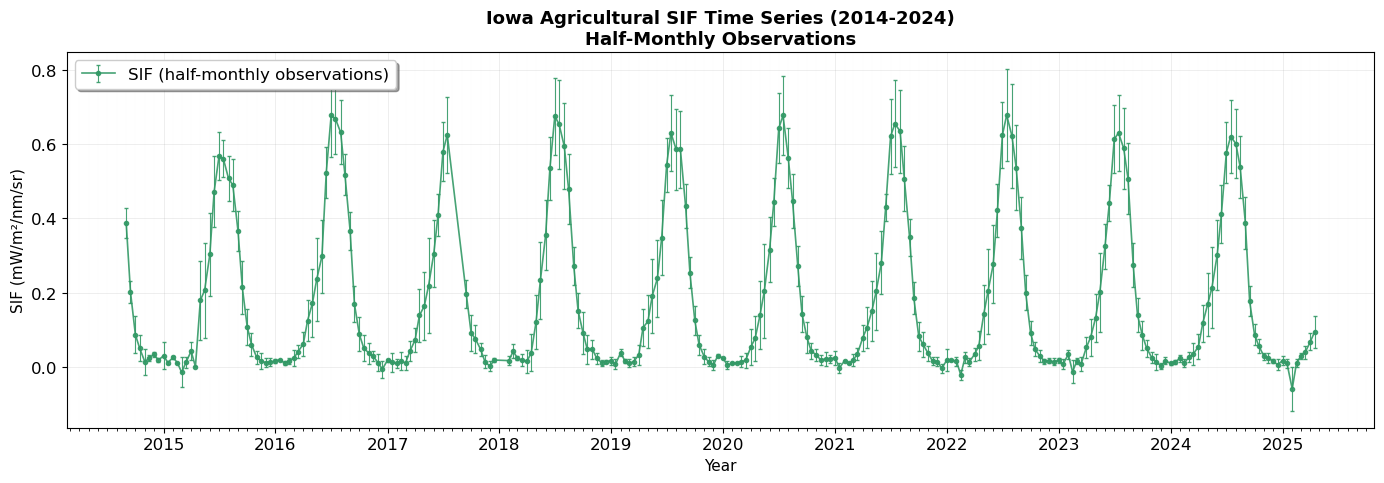

✓ Half-monthly time series plot saved!
  - Total observations: 251
  - 'a' observations (1st half): 125
  - 'b' observations (2nd half): 126


In [34]:
# ---- Plot half-monthly SIF as a continuous time series ----

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare the data
plot_df = (
    df[["date", "ab", "sif_mean", "sif_sd"]]
      .dropna(subset=["date", "ab", "sif_mean"])
      .sort_values(["date", "ab"])
      .copy()
)
plot_df["date"] = pd.to_datetime(plot_df["date"])

# Create proper datetime for each half-month
# 'a' = 1st of month, 'b' = 15th of month (approximate mid-point)
plot_df["date_adjusted"] = plot_df.apply(
    lambda row: row["date"] if row["ab"] == "a" else row["date"] + pd.Timedelta(days=14),
    axis=1
)

# Create the figure
fig, ax = plt.subplots(figsize=(14, 5))

# Single continuous line with error bars
ax.errorbar(
    plot_df["date_adjusted"], 
    plot_df["sif_mean"], 
    yerr=plot_df["sif_sd"],
    fmt="-o",
    color=(0.2, 0.6, 0.4),  # Green color for vegetation
    mfc=(0.2, 0.6, 0.4),
    mec=(0.2, 0.6, 0.4),
    ms=3,
    elinewidth=0.8,
    ecolor=(0.2, 0.6, 0.4, 0.3),  # Translucent error bars
    capsize=1.5,
    linewidth=1.2,
    label="SIF (half-monthly observations)",
    zorder=3,
    alpha=0.9
)

# Format x-axis with year labels
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Labels and formatting
ax.set_title("Iowa Agricultural SIF Time Series (2014-2024)\nHalf-Monthly Observations", 
             fontsize=13, fontweight='bold')
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("SIF (mW/m²/nm/sr)", fontsize=11)
ax.legend(loc="upper left", frameon=True, fancybox=True, shadow=True)
ax.grid(which="major", alpha=0.3, linestyle='-', linewidth=0.5)
ax.grid(which="minor", alpha=0.15, linestyle=':', linewidth=0.3)

fig.tight_layout()

# Save to file
fig.savefig("/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_halfmonthly_timeseries.png", 
            dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

print("✓ Half-monthly time series plot saved!")
print(f"  - Total observations: {len(plot_df)}")
print(f"  - 'a' observations (1st half): {len(plot_df[plot_df['ab']=='a'])}")
print(f"  - 'b' observations (2nd half): {len(plot_df[plot_df['ab']=='b'])}")


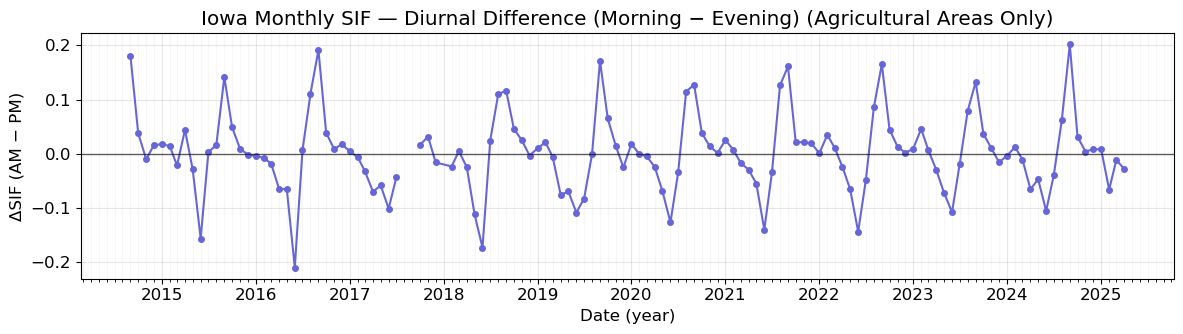

In [ ]:
# NOTE: This cell was REMOVED
# Previously contained "diurnal difference" plot (morning - evening)
# However, 'a' and 'b' represent first/second half of month, NOT morning/evening
# Therefore, this analysis is not applicable and has been removed
# The difference between first and second half of month is not a meaningful metric for diurnal patterns

print("=" * 60)
print("SKIPPED: Diurnal difference plot")
print("=" * 60)
print("This plot was removed because 'a' and 'b' represent")
print("half-monthly periods, not morning/evening observations.")
print("=" * 60)


## 4. Seasonal Averages Across All Years

**Purpose:** Aggregate half-monthly observations across the 10-year period (2014-2024) to reveal Iowa's typical seasonal photosynthetic cycle.

**Workflow:**

**i. Calculate Monthly Statistics:**
- Group half-monthly data by calendar month (Jan-Dec)
- Compute separate averages for first half ('a') and second half ('b') observations
- Calculate combined monthly averages pooling both halves
- Compute mean, standard deviation, and observation counts

**ii. Visualize Seasonal Cycle:**
- **Main line (solid):** Combined monthly average showing typical seasonal pattern
- **Secondary lines (dashed):** First vs. second half of month to reveal intra-monthly variation
- Peak SIF occurs in July (~0.617 mW/m²/nm/sr)
- Minimal SIF occurs in winter months (Jan-Feb, Dec < 0.015)

**Key Outputs:**
- Monthly statistics tables (first half, second half, combined)
- Seasonal cycle plot saved to `figures/iowa_seasonal_sif_cycle.png`
- ~10 observations per month across the decade

**Scientific Insight:** The pronounced summer peak reflects corn/soybean photosynthetic activity during the critical reproductive growth stages (tasseling, grain fill).

#### i. Calculate averages

In [35]:
# Step 1: Calculate monthly averages across all years
print("=" * 60)
print("STEP 1: CALCULATING MONTHLY AVERAGES")
print("=" * 60)

# Calculate average SIF for each month across all years
# We'll create separate averages for first half (a) and second half (b)

print("1. First half of month (a) averages:")
first_half_data = df[df['ab'] == 'a']  # Filter for first half
first_half_monthly = first_half_data.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(first_half_monthly)
print()

print("2. Second half of month (b) averages:")
second_half_data = df[df['ab'] == 'b']  # Filter for second half
second_half_monthly = second_half_data.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(second_half_monthly)
print()

print("3. Combined (a + b) monthly averages:")
# For combined, we'll average both halves of each month
combined_monthly = df.groupby('month')['sif_mean'].agg(['mean', 'std', 'count'])
print(combined_monthly)
print()

print("Summary:")
print(f"- First half data: {len(first_half_data)} records")
print(f"- Second half data: {len(second_half_data)} records") 
print(f"- Total data: {len(df)} records")
print(f"- Months covered: {sorted(df['month'].unique())}")
print()

print("✓ Monthly averages calculated successfully!")
print("Next step: We'll create the seasonal cycle plot.")


STEP 1: CALCULATING MONTHLY AVERAGES
1. First half of month (a) averages:
           mean       std  count
month                           
1      0.018525  0.005598     10
2      0.012154  0.025701     11
3      0.015862  0.012224     11
4      0.050637  0.019111     11
5      0.148782  0.020976     10
6      0.299654  0.030903     10
7      0.612557  0.045332     10
8      0.592540  0.039489      9
9      0.348114  0.056722     10
10     0.091875  0.013177     11
11     0.030874  0.009937     11
12     0.012553  0.009203     11

2. Second half of month (b) averages:
           mean       std  count
month                           
1      0.009220  0.006387     10
2      0.009123  0.016239     11
3      0.024458  0.013360     11
4      0.084772  0.040867     11
5      0.210796  0.014450     10
6      0.443698  0.054975     10
7      0.640332  0.035133     10
8      0.512324  0.039755      9
9      0.184380  0.034004     11
10     0.054146  0.009019     11
11     0.018123  0.005245    

#### ii. Plot the seasonal cycle

STEP 2: CREATING SEASONAL CYCLE PLOT
Preparing data for plotting...
Months with data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
First half means: [0.0185246  0.01215393 0.01586169 0.05063728 0.14878218 0.29965403
 0.61255682 0.5925404  0.34811388 0.09187492 0.03087435 0.01255295]
Second half means: [0.00922041 0.00912271 0.02445758 0.08477163 0.21079575 0.44369752
 0.64033236 0.51232443 0.18437981 0.05414583 0.0181232  0.01231838]
Combined means: [0.0138725  0.01063832 0.02015964 0.06770445 0.17978897 0.37167578
 0.62644459 0.55243241 0.26234842 0.07301038 0.02449878 0.01243566]

Creating the seasonal cycle plot...
✓ Plot saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_seasonal_sif_cycle.png


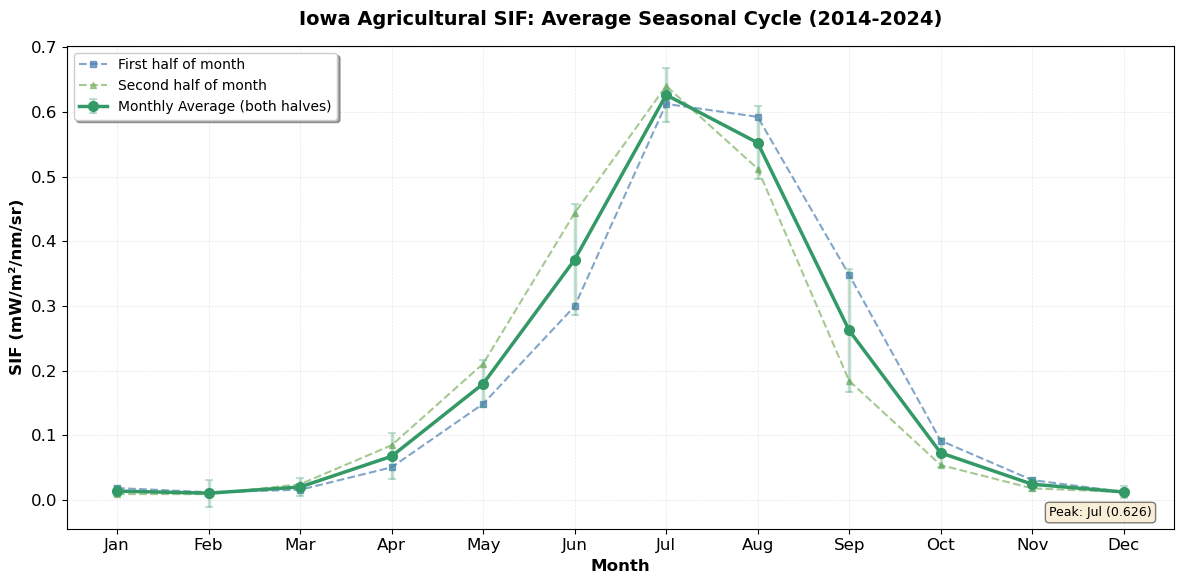

✓ Seasonal cycle plot created and saved!
  Peak SIF occurs in Jul
  Peak value: 0.626 mW/m²/nm/sr
  Shows monthly average (solid line) and half-monthly values (dashed lines)


In [36]:
# Step 2: Create the seasonal cycle plot
print("=" * 60)
print("STEP 2: CREATING SEASONAL CYCLE PLOT")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np

# Step 2a: Prepare the data for plotting
print("Preparing data for plotting...")

# Create month names for better x-axis labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Get the month numbers that we have data for
months_with_data = sorted(first_half_monthly.index)
print(f"Months with data: {months_with_data}")

# Extract the mean values for each line
first_half_means = first_half_monthly['mean'].values
second_half_means = second_half_monthly['mean'].values
combined_means = combined_monthly['mean'].values

# Extract standard deviations for error bars
first_half_stds = first_half_monthly['std'].values
second_half_stds = second_half_monthly['std'].values
combined_stds = combined_monthly['std'].values

print(f"First half means: {first_half_means}")
print(f"Second half means: {second_half_means}")
print(f"Combined means: {combined_means}")
print()

# Step 2b: Create the seasonal cycle plot
print("Creating the seasonal cycle plot...")

# Define colors
first_half_color = (0.3, 0.5, 0.7)  # Darker blue
second_half_color = (0.5, 0.7, 0.4)  # Darker green
combined_color = (0.2, 0.6, 0.4)  # Main green for combined

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Combined monthly average (main line - most prominent)
ax.errorbar(months_with_data, combined_means, yerr=combined_stds,
            fmt='-o', linewidth=2.5, markersize=7,
            color=combined_color, 
            ecolor=(combined_color[0], combined_color[1], combined_color[2], 0.3),
            capsize=3, capthick=1.5,
            label='Monthly Average (both halves)', zorder=3)

# First half (lighter line)
ax.plot(months_with_data, first_half_means, '--s', linewidth=1.5, markersize=5,
        color=first_half_color, alpha=0.7,
        label='First half of month', zorder=2)

# Second half (lighter line)
ax.plot(months_with_data, second_half_means, '--^', linewidth=1.5, markersize=5,
        color=second_half_color, alpha=0.7,
        label='Second half of month', zorder=2)

# Formatting
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('SIF (mW/m²/nm/sr)', fontsize=12, fontweight='bold')
ax.set_title('Iowa Agricultural SIF: Average Seasonal Cycle (2014-2024)', 
             fontsize=14, fontweight='bold', pad=15)

# Set x-axis to show month names
ax.set_xticks(months_with_data)
ax.set_xticklabels([month_names[m-1] for m in months_with_data], fontsize=12)

# Add legend and grid
ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add peak month annotation
peak_month = months_with_data[np.argmax(combined_means)]
peak_value = np.max(combined_means)
ax.text(0.98, 0.02, 
        f'Peak: {month_names[peak_month-1]} ({peak_value:.3f})',
        transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save the figure
output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_seasonal_sif_cycle.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Plot saved to: {output_path}")

plt.show()

print("✓ Seasonal cycle plot created and saved!")
print(f"  Peak SIF occurs in {month_names[peak_month-1]}")
print(f"  Peak value: {peak_value:.3f} mW/m²/nm/sr")
print("  Shows monthly average (solid line) and half-monthly values (dashed lines)")


## 5. SIF Anomaly Analysis

**Purpose:** Identify unusual years and seasons by calculating deviations from long-term monthly means.

**Methodology:**
1. **Calculate Monthly Climatology:** Compute average SIF for each calendar month (Jan-Dec) across all years (2014-2024)
2. **Calculate Anomalies:** For each observation, subtract the corresponding monthly climatology to get anomaly
3. **Visualize Anomalies:** Plot time series showing deviations from normal, highlighting unusual periods

**Scientific Value:** 
- Identifies drought years, wet years, or unusual growing seasons
- Shows interannual variability in crop photosynthetic activity
- Helps detect climate impacts on agricultural productivity

#### i.  Calculate monthly climatology and anomalies

Iowa's SIF data. First, it computes the average SIF value for each calendar month (Jan-Dec) across all years (2014-2024) to establish the "normal" seasonal pattern. Then it calculates anomalies by subtracting each observation's monthly climatology from its actual SIF value, showing how much each measurement deviates from the long-term monthly average. The code also creates a datetime column for plotting and prints summary statistics showing the range and distribution of anomalies. This creates the foundation for identifying unusual months or years when agricultural productivity was significantly above or below normal.

In [ ]:
print("=" * 60)
print("STEP 1: CALCULATING MONTHLY CLIMATOLOGY")
print("=" * 60)

# Step 1: Calculate monthly climatology (average SIF for each month across all years)
monthly_climatology = df.groupby('month')['sif_mean'].mean()
print("Monthly climatology (average SIF across all years):")
for month in range(1, 13):
    if month in monthly_climatology.index:
        print(f"  {month:2d}: {monthly_climatology[month]:.4f} mW/m²/nm/sr")
    else:
        print(f"  {month:2d}: No data")

print()
print(f"✓ Calculated climatology for {len(monthly_climatology)} months")
print()

# Step 2: Calculate anomalies (deviation from monthly climatology)
print("STEP 2: CALCULATING ANOMALIES")
print("=" * 60)

# Add climatology values to the dataframe
df['monthly_climatology'] = df['month'].map(monthly_climatology)

# Calculate anomaly (observed - climatology)
df['sif_anomaly'] = df['sif_mean'] - df['monthly_climatology']

# Create a proper datetime for plotting
df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['ab'].map({'a': 0, 'b': 14}), unit='days')

print("Anomaly calculation complete!")
print(f"  Total observations: {len(df)}")
print(f"  Anomaly range: {df['sif_anomaly'].min():.4f} to {df['sif_anomaly'].max():.4f}")
print(f"  Mean anomaly: {df['sif_anomaly'].mean():.4f}")
print(f"  Std anomaly: {df['sif_anomaly'].std():.4f}")

# Show some examples
print()
print("Sample anomalies:")
sample_df = df[['datetime', 'year', 'month', 'ab', 'sif_mean', 'monthly_climatology', 'sif_anomaly']].head(10)
print(sample_df.to_string(index=False))

# Step 1: Calculate monthly climatology (average SIF for each month across all years)
monthly_climatology = df.groupby('month')['sif_mean'].mean()
print("Monthly climatology (average SIF across all years):")
for month in range(1, 13):
    if month in monthly_climatology.index:
        print(f"  {month:2d}: {monthly_climatology[month]:.4f} mW/m²/nm/sr")
    else:
        print(f"  {month:2d}: No data")

print()
print(f"✓ Calculated climatology for {len(monthly_climatology)} months")
print()

# Step 2: Calculate anomalies (deviation from monthly climatology)
print("STEP 2: CALCULATING ANOMALIES")
print("=" * 60)

# Add climatology values to the dataframe
df['monthly_climatology'] = df['month'].map(monthly_climatology)

# Calculate anomaly (observed - climatology)
df['sif_anomaly'] = df['sif_mean'] - df['monthly_climatology']

# Create a proper datetime for plotting
df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['ab'].map({'a': 0, 'b': 14}), unit='days')

print("Anomaly calculation complete!")
print(f"  Total observations: {len(df)}")
print(f"  Anomaly range: {df['sif_anomaly'].min():.4f} to {df['sif_anomaly'].max():.4f}")
print(f"  Mean anomaly: {df['sif_anomaly'].mean():.4f}")
print(f"  Std anomaly: {df['sif_anomaly'].std():.4f}")

# Show some examples
print()
print("Sample anomalies:")
sample_df = df[['datetime', 'year', 'month', 'ab', 'sif_mean', 'monthly_climatology', 'sif_anomaly']].head(10)
print(sample_df.to_string(index=False))


STEP 1: CALCULATING MONTHLY CLIMATOLOGY
Monthly climatology (average SIF across all years):
   1: 0.0139 mW/m²/nm/sr
   2: 0.0106 mW/m²/nm/sr
   3: 0.0202 mW/m²/nm/sr
   4: 0.0677 mW/m²/nm/sr
   5: 0.1798 mW/m²/nm/sr
   6: 0.3717 mW/m²/nm/sr
   7: 0.6264 mW/m²/nm/sr
   8: 0.5524 mW/m²/nm/sr
   9: 0.2623 mW/m²/nm/sr
  10: 0.0730 mW/m²/nm/sr
  11: 0.0245 mW/m²/nm/sr
  12: 0.0124 mW/m²/nm/sr

✓ Calculated climatology for 12 months

STEP 2: CALCULATING ANOMALIES
Anomaly calculation complete!
  Total observations: 251
  Anomaly range: -0.1331 to 0.1703
  Mean anomaly: -0.0000
  Std anomaly: 0.0442

Sample anomalies:
  datetime  year  month ab  sif_mean  monthly_climatology  sif_anomaly
2014-09-01  2014      9  a  0.387701             0.262348     0.125352
2014-09-15  2014      9  b  0.201593             0.262348    -0.060755
2014-10-01  2014     10  a  0.086220             0.073010     0.013209
2014-10-15  2014     10  b  0.049608             0.073010    -0.023403
2014-11-01  2014     11  a

#### ii. Anomaly Heat Map

This code chunk creates a **color-coded heatmap** showing SIF anomalies across months and years. First, it reorganizes the anomaly data into a grid format using `pivot_table()`, with years as rows and months as columns, where each cell contains the average anomaly for that month/year combination. Then it uses `matplotlib.imshow()` to create a visual heatmap with a red-blue color scheme (`RdBu_r`) where red cells indicate above-normal SIF (good growing conditions) and blue cells show below-normal SIF (stressful conditions). The code adds text annotations showing the exact anomaly values in each cell, converts month numbers to month names for readability, and includes a colorbar legend. Finally, it analyzes and prints which years had the most extreme anomalies overall, helping identify the most unusual growing seasons in the dataset.


STEP 4: CREATING ANOMALY HEATMAP
✓ Anomaly heatmap saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_anomalies_heatmap.png


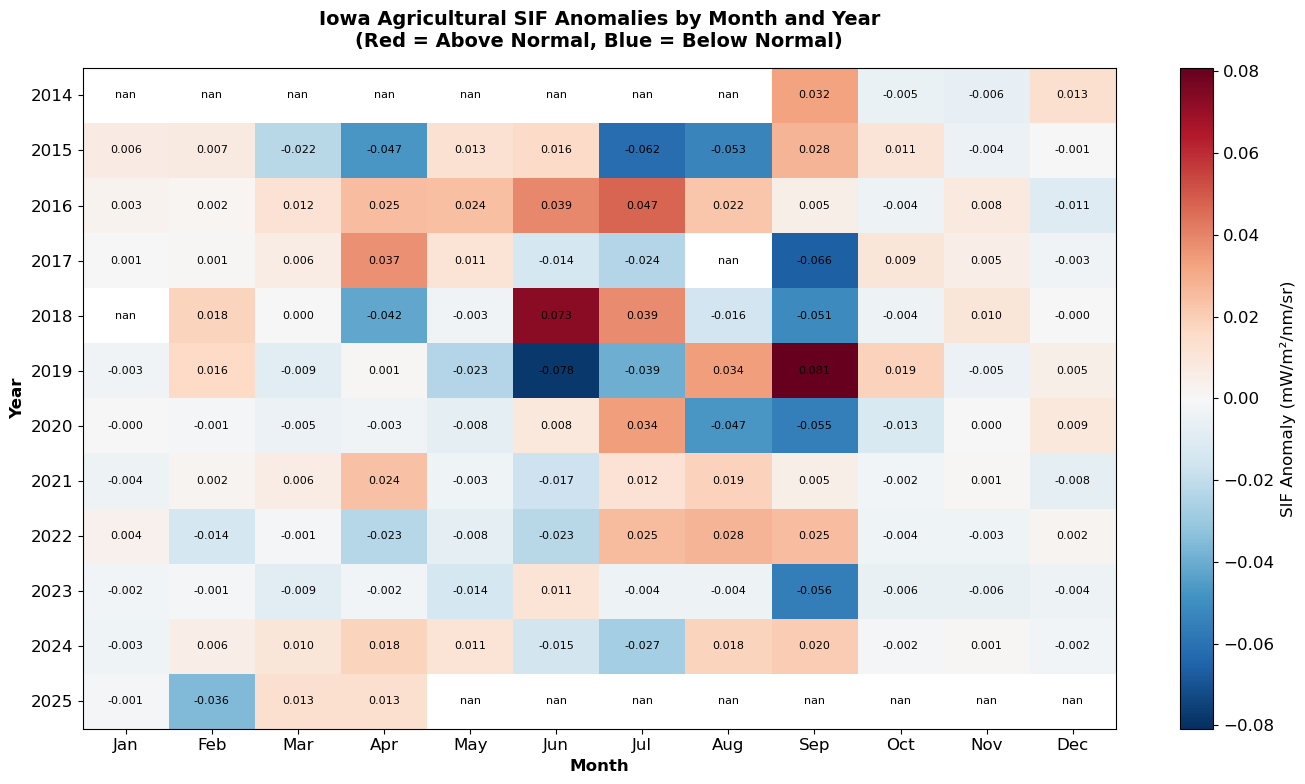


HEATMAP INSIGHTS:
Red cells = Above normal SIF (good growing conditions)
Blue cells = Below normal SIF (stressful conditions)

Most anomalous years (by average absolute anomaly):
      mean_anomaly  std_anomaly  abs_mean_anomaly
year                                             
2018      0.002202     0.054349          0.036428
2016      0.014286     0.052268          0.036032
2015     -0.009122     0.045929          0.033671
2019     -0.000225     0.054003          0.033178
2014      0.008431     0.053667          0.032704


In [18]:

print("=" * 60)
print("STEP 4: CREATING ANOMALY HEATMAP")
print("=" * 60)

# Alternative approach using matplotlib instead of seaborn
import matplotlib.pyplot as plt
import numpy as np

# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(values='sif_anomaly', index='year', columns='month', aggfunc='mean')

# Create the heatmap using matplotlib
fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap using imshow
im = ax.imshow(heatmap_data.values, cmap='RdBu_r', aspect='auto', vmin=-heatmap_data.abs().max().max(), vmax=heatmap_data.abs().max().max())

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('SIF Anomaly (mW/m²/nm/sr)', fontsize=12)

# Set ticks and labels
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns)
ax.set_yticklabels(heatmap_data.index)

# Add month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels([month_names[int(x)-1] for x in heatmap_data.columns])

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        text = ax.text(j, i, f'{heatmap_data.iloc[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=8)

# Formatting
ax.set_title('Iowa Agricultural SIF Anomalies by Month and Year\n(Red = Above Normal, Blue = Below Normal)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Year', fontsize=12, fontweight='bold')

plt.tight_layout()

# Save the heatmap
heatmap_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_anomalies_heatmap.png"
fig.savefig(heatmap_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Anomaly heatmap saved to: {heatmap_path}")

plt.show()

# Print some insights
print()
print("HEATMAP INSIGHTS:")
print("=" * 40)
print("Red cells = Above normal SIF (good growing conditions)")
print("Blue cells = Below normal SIF (stressful conditions)")
print()
print("Most anomalous years (by average absolute anomaly):")
year_anomalies = df.groupby('year')['sif_anomaly'].agg(['mean', 'std', lambda x: abs(x).mean()])
year_anomalies.columns = ['mean_anomaly', 'std_anomaly', 'abs_mean_anomaly']
year_anomalies = year_anomalies.sort_values('abs_mean_anomaly', ascending=False)
print(year_anomalies.head())

#### iii. Monthly Anomaly Time Series Plot

This code chunk creates an **improved monthly anomaly time series plot** that's much cleaner and easier to interpret than the half-monthly version. First, it calculates monthly anomalies by averaging both halves ('a' and 'b') for each month, reducing the data from 251 half-monthly points to about 120 monthly points for clearer visualization. Then it creates a line plot with markers showing anomalies over time, including reference lines for zero anomaly and ±1 standard deviation to help identify normal vs. extreme conditions. The code highlights extreme anomalies (>2σ) with colored scatter points and adds text labels showing the specific month and year (like "Jul 2016" or "Aug 2018") positioned to avoid overlap, making it easy to identify exactly when unusual growing conditions occurred. Finally, it prints comprehensive statistics about the monthly anomalies and lists all extreme months with their values, providing both visual and numerical insights into Iowa's agricultural productivity patterns.

IMPROVED: MONTHLY ANOMALY TIME SERIES PLOT
Created monthly anomalies: 126 months
Date range: 2014-09-01 00:00:00 to 2025-04-01 00:00:00
✓ Monthly anomaly plot saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_monthly_anomalies_timeseries.png


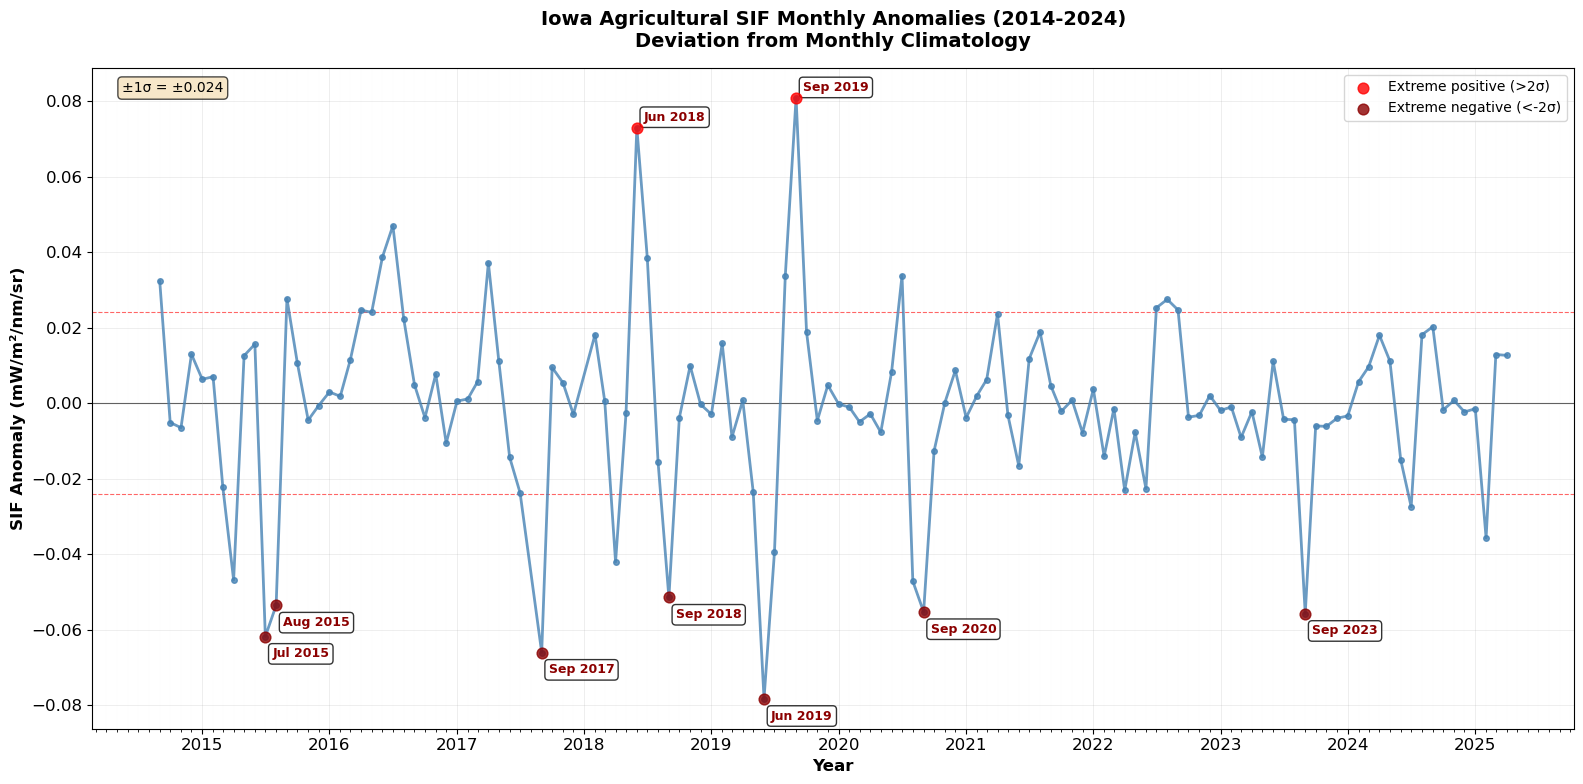


MONTHLY ANOMALY SUMMARY STATISTICS:
Total months: 126
Mean anomaly: -0.0003 mW/m²/nm/sr
Standard deviation: 0.0240 mW/m²/nm/sr
Range: -0.0782 to 0.0808

Extreme positive months (>2σ): 2
Extreme negative months (<-2σ): 7

Extreme months:
  Sep 2019: 0.081
  Jun 2018: 0.073
  Sep 2018: -0.051
  Aug 2015: -0.053
  Sep 2020: -0.055
  Sep 2023: -0.056
  Jul 2015: -0.062
  Sep 2017: -0.066
  Jun 2019: -0.078


In [19]:
print("=" * 60)
print("IMPROVED: MONTHLY ANOMALY TIME SERIES PLOT")
print("=" * 60)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Calculate monthly anomalies (average of both halves for each month)
monthly_anomalies = df.groupby(['year', 'month'])['sif_anomaly'].mean().reset_index()
monthly_anomalies['datetime'] = pd.to_datetime(monthly_anomalies[['year', 'month']].assign(day=1))

print(f"Created monthly anomalies: {len(monthly_anomalies)} months")
print(f"Date range: {monthly_anomalies['datetime'].min()} to {monthly_anomalies['datetime'].max()}")

# Create the figure
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the monthly anomaly time series
ax.plot(monthly_anomalies['datetime'], monthly_anomalies['sif_anomaly'], 
        color='steelblue', linewidth=2, alpha=0.8, zorder=2, marker='o', markersize=4)

# Add zero line (no anomaly)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7, zorder=1)

# Add ±1 standard deviation lines
anomaly_std = monthly_anomalies['sif_anomaly'].std()
ax.axhline(y=anomaly_std, color='red', linestyle='--', linewidth=0.8, alpha=0.6, zorder=1)
ax.axhline(y=-anomaly_std, color='red', linestyle='--', linewidth=0.8, alpha=0.6, zorder=1)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Labels and formatting
ax.set_title('Iowa Agricultural SIF Monthly Anomalies (2014-2024)\nDeviation from Monthly Climatology', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('SIF Anomaly (mW/m²/nm/sr)', fontsize=12, fontweight='bold')

# Add grid
ax.grid(which='major', alpha=0.3, linestyle='-', linewidth=0.5)
ax.grid(which='minor', alpha=0.15, linestyle=':', linewidth=0.3)

# Add legend
ax.text(0.02, 0.98, f'±1σ = ±{anomaly_std:.3f}', 
         transform=ax.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Highlight extreme anomalies (>2σ) and add labels
extreme_positive = monthly_anomalies['sif_anomaly'] > 2 * anomaly_std
extreme_negative = monthly_anomalies['sif_anomaly'] < -2 * anomaly_std

# Month names for labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if extreme_positive.any():
    extreme_pos_data = monthly_anomalies[extreme_positive]
    ax.scatter(extreme_pos_data['datetime'], extreme_pos_data['sif_anomaly'],
               color='red', s=60, alpha=0.8, zorder=4, label='Extreme positive (>2σ)')
    
    # Add labels for extreme positive points
    for _, row in extreme_pos_data.iterrows():
        month_name = month_names[int(row['month'])-1]
        ax.annotate(f"{month_name} {int(row['year'])}", 
                   (row['datetime'], row['sif_anomaly']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

if extreme_negative.any():
    extreme_neg_data = monthly_anomalies[extreme_negative]
    ax.scatter(extreme_neg_data['datetime'], extreme_neg_data['sif_anomaly'],
               color='darkred', s=60, alpha=0.8, zorder=4, label='Extreme negative (<-2σ)')
    
    # Add labels for extreme negative points
    for _, row in extreme_neg_data.iterrows():
        month_name = month_names[int(row['month'])-1]
        ax.annotate(f"{month_name} {int(row['year'])}", 
                   (row['datetime'], row['sif_anomaly']),
                   xytext=(5, -15), textcoords='offset points',
                   fontsize=9, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Add legend if there are extreme values
if extreme_positive.any() or extreme_negative.any():
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()

# Save the figure
output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/iowa_sif_monthly_anomalies_timeseries.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Monthly anomaly plot saved to: {output_path}")

plt.show()

# Print summary statistics
print()
print("MONTHLY ANOMALY SUMMARY STATISTICS:")
print("=" * 50)
print(f"Total months: {len(monthly_anomalies)}")
print(f"Mean anomaly: {monthly_anomalies['sif_anomaly'].mean():.4f} mW/m²/nm/sr")
print(f"Standard deviation: {anomaly_std:.4f} mW/m²/nm/sr")
print(f"Range: {monthly_anomalies['sif_anomaly'].min():.4f} to {monthly_anomalies['sif_anomaly'].max():.4f}")
print()
print(f"Extreme positive months (>2σ): {extreme_positive.sum()}")
print(f"Extreme negative months (<-2σ): {extreme_negative.sum()}")
print()
print("Extreme months:")
if extreme_positive.any() or extreme_negative.any():
    extreme_months = monthly_anomalies[extreme_positive | extreme_negative].copy()
    extreme_months['month_name'] = extreme_months['month'].map(lambda x: month_names[int(x)-1])
    extreme_months = extreme_months.sort_values('sif_anomaly', ascending=False)
    for _, row in extreme_months.iterrows():
        print(f"  {row['month_name']} {int(row['year'])}: {row['sif_anomaly']:.3f}")
else:
    print("No extreme anomalies found (>2σ)")


#### iv. Spatial Comparison of Anomaly Months

JUNE COMPARISON: PIXEL-BY-PIXEL CLIMATOLOGY MAPS
Loading June data for all years to calculate pixel climatology...
No data found for 2014-06
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 526244
    Resized agricultural pixels: 4123
  ✓ Loaded June 2015
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 530088
    Resized agricultural pixels: 4152
  ✓ Loaded June 2016
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 540625
    Resized agricultural pixels: 4248
  ✓ Loaded June 2017
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 542239
    Resized agricultural pixels: 4258
  ✓ Loaded June 2018
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 537352
    Resized agricultural pixels: 4215
  ✓ Loaded June 2019
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 547805
    Resized agricultural pixels: 429

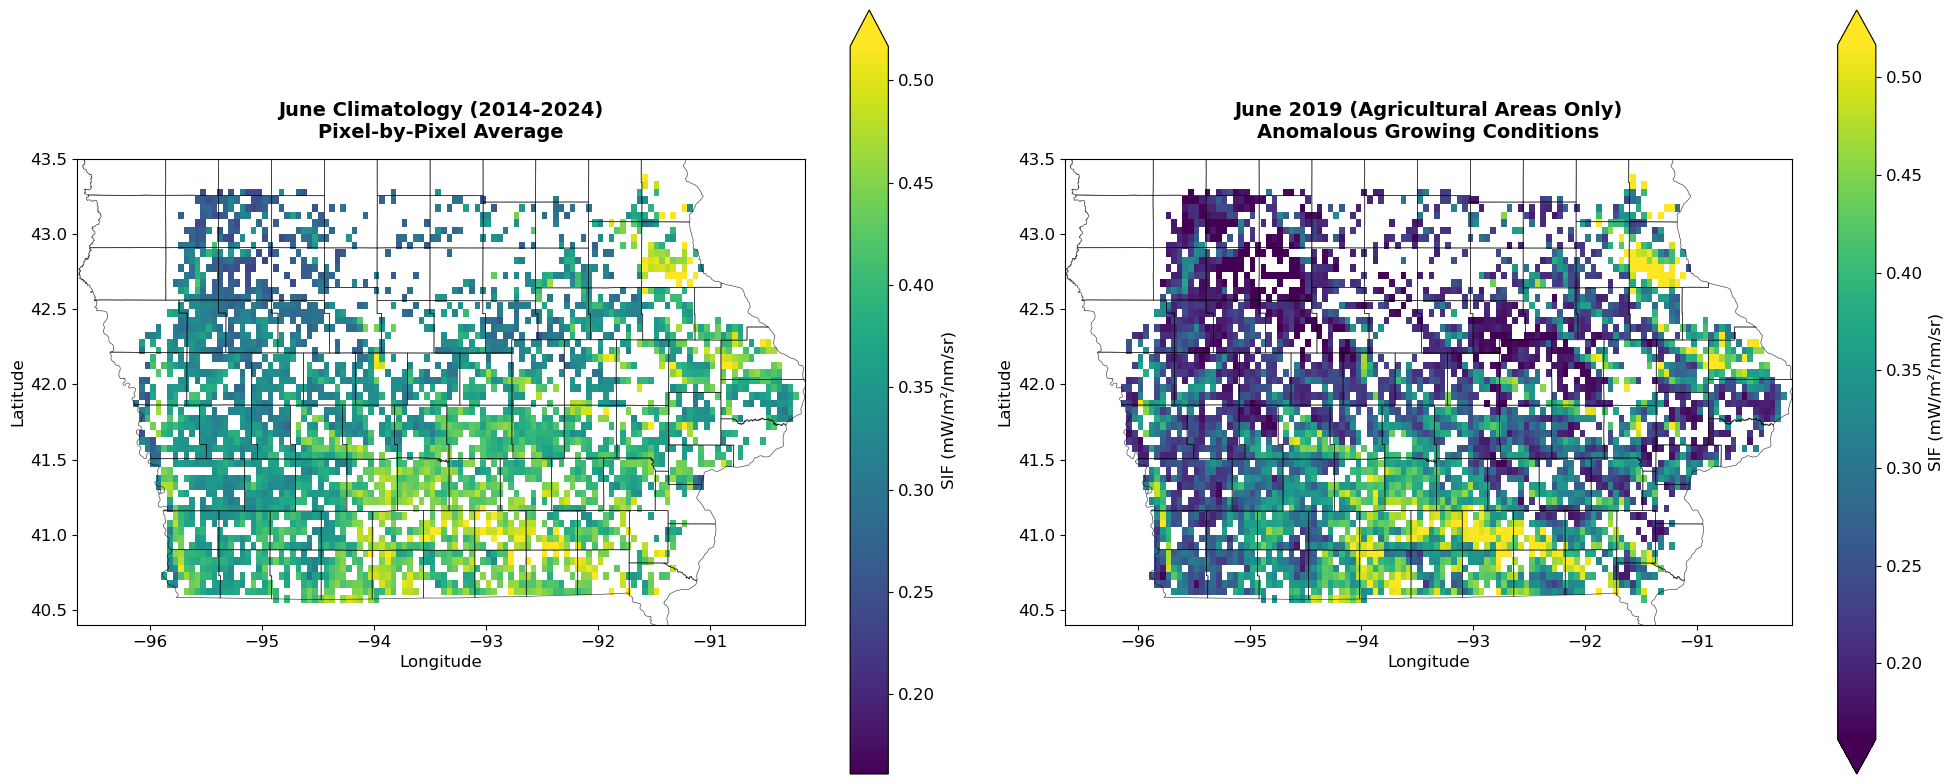


JUNE COMPARISON STATISTICS (Agricultural Areas Only):
June climatology (spatial mean): 0.3739 ± 0.0628
June 2019 SIF (agricultural): 0.2930 ± 0.0990
Difference: -0.0809 mW/m²/nm/sr
Agricultural pixels: 3667


In [25]:
print("=" * 60)
print("JUNE COMPARISON: PIXEL-BY-PIXEL CLIMATOLOGY MAPS")
print("=" * 60)

# Load June data for all years to calculate pixel-by-pixel climatology
print("Loading June data for all years to calculate pixel climatology...")
june_data_all_years = []

for year in range(2014, 2025):
    june_sif = load_sif_for_month(year, 6)
    if june_sif is not None:
        # Apply agricultural mask for this year
        june_masked = june_sif.where(resize_mask_to_match_data(ag_masks[year], june_sif.shape) == 1)
        june_data_all_years.append(june_masked)
        print(f"  ✓ Loaded June {year}")

if len(june_data_all_years) == 0:
    print("❌ No June data found!")
else:
    print(f"✓ Loaded {len(june_data_all_years)} years of June data")
    
    # Calculate pixel-by-pixel climatology (mean across all years for each pixel)
    print("Calculating pixel-by-pixel June climatology...")
    june_climatology_map = sum(june_data_all_years) / len(june_data_all_years)
    print("✓ Calculated June climatology map")
    
    # Load June 2019 specifically
    june_2019 = load_sif_for_month(2019, 6)
    
    if june_2019 is not None:
        print("✓ Loaded June 2019 data")
        
        # Apply agricultural mask to June 2019
        june_2019_masked = june_2019.where(resize_mask_to_match_data(ag_masks[2019], june_2019.shape) == 1)
        
        # Create side-by-side comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Determine color scale limits (use same scale for both maps)
        all_values = np.concatenate([
            june_climatology_map.values.flatten(),
            june_2019_masked.values.flatten()
        ])
        valid_values = all_values[~np.isnan(all_values)]
        vmin = np.percentile(valid_values, 2)  # 2nd percentile
        vmax = np.percentile(valid_values, 98)  # 98th percentile
        
        # Plot June climatology map (pixel-by-pixel average)
        im1 = june_climatology_map.plot(ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax,
                                       add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
        ax1.set_title('June Climatology (2014-2024)\nPixel-by-Pixel Average', 
                     fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        
        # Plot June 2019 spatial map with agricultural masking
        im2 = june_2019_masked.plot(ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax, 
                                   add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
        ax2.set_title('June 2019 (Agricultural Areas Only)\nAnomalous Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        
        plt.tight_layout()
        
        # Save the comparison
        output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/june_comparison_spatial_climatology.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ June comparison saved to: {output_path}")
        
        plt.show()
        
        # Calculate and print statistics (only for agricultural areas)
        print()
        print("JUNE COMPARISON STATISTICS (Agricultural Areas Only):")
        print("=" * 55)
        print(f"June climatology (spatial mean): {june_climatology_map.mean().values:.4f} ± {june_climatology_map.std().values:.4f}")
        print(f"June 2019 SIF (agricultural): {june_2019_masked.mean().values:.4f} ± {june_2019_masked.std().values:.4f}")
        print(f"Difference: {june_2019_masked.mean().values - june_climatology_map.mean().values:.4f} mW/m²/nm/sr")
        print(f"Agricultural pixels: {np.sum(~np.isnan(june_2019_masked.values))}")
        
    else:
        print("❌ Could not load June 2019 data")


SEPTEMBER COMPARISON: PIXEL-BY-PIXEL CLIMATOLOGY MAPS
Loading September data for all years to calculate pixel climatology...
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 546963
    Resized agricultural pixels: 4316
  ✓ Loaded September 2014
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 526244
    Resized agricultural pixels: 4123
  ✓ Loaded September 2015
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 530088
    Resized agricultural pixels: 4152
  ✓ Loaded September 2016
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 540625
    Resized agricultural pixels: 4248
  ✓ Loaded September 2017
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 542239
    Resized agricultural pixels: 4258
  ✓ Loaded September 2018
    Resized mask from (696, 1447) to (62, 130)
    Original agricultural pixels: 537352
    Resized agricultural pi

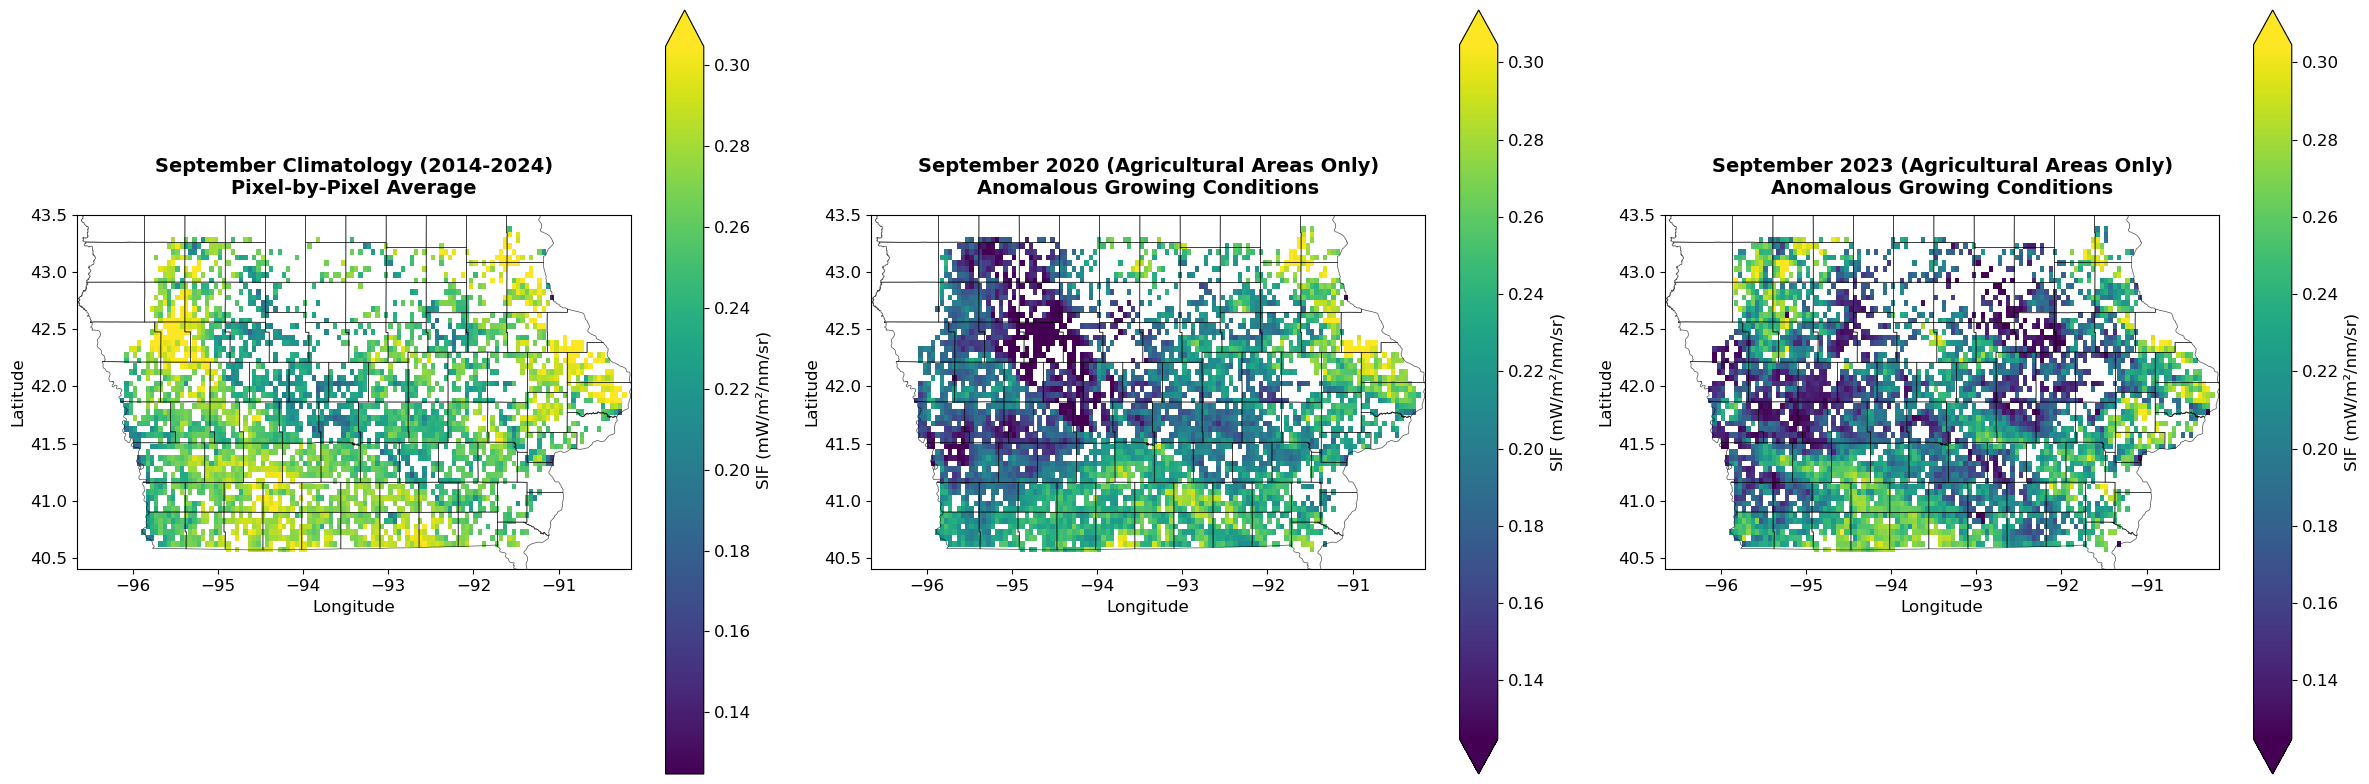


SEPTEMBER COMPARISON STATISTICS (Agricultural Areas Only):
September climatology (spatial mean): 0.2598 ± 0.0280
September 2020 SIF (agricultural): 0.2070 ± 0.0443
September 2023 SIF (agricultural): 0.2066 ± 0.0448

Differences from climatology:
  2020: -0.0528 mW/m²/nm/sr
  2023: -0.0532 mW/m²/nm/sr

Agricultural pixels:
  2020: 3745
  2023: 3671


In [26]:
print("=" * 60)
print("SEPTEMBER COMPARISON: PIXEL-BY-PIXEL CLIMATOLOGY MAPS")
print("=" * 60)

# Load September data for all years to calculate pixel-by-pixel climatology
print("Loading September data for all years to calculate pixel climatology...")
september_data_all_years = []

for year in range(2014, 2025):
    sep_sif = load_sif_for_month(year, 9)
    if sep_sif is not None:
        # Apply agricultural mask for this year
        sep_masked = sep_sif.where(resize_mask_to_match_data(ag_masks[year], sep_sif.shape) == 1)
        september_data_all_years.append(sep_masked)
        print(f"  ✓ Loaded September {year}")

if len(september_data_all_years) == 0:
    print("❌ No September data found!")
else:
    print(f"✓ Loaded {len(september_data_all_years)} years of September data")
    
    # Calculate pixel-by-pixel climatology (mean across all years for each pixel)
    print("Calculating pixel-by-pixel September climatology...")
    september_climatology_map = sum(september_data_all_years) / len(september_data_all_years)
    print("✓ Calculated September climatology map")
    
    # Load September 2020 and 2023 specifically
    september_2020 = load_sif_for_month(2020, 9)
    september_2023 = load_sif_for_month(2023, 9)
    
    if september_2020 is not None and september_2023 is not None:
        print("✓ Loaded September 2020 and 2023 data")
        
        # Apply agricultural masks
        september_2020_masked = september_2020.where(resize_mask_to_match_data(ag_masks[2020], september_2020.shape) == 1)
        september_2023_masked = september_2023.where(resize_mask_to_match_data(ag_masks[2023], september_2023.shape) == 1)
        
        # Create three-panel comparison
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        
        # Determine color scale limits (use same scale for all three maps)
        all_values = np.concatenate([
            september_climatology_map.values.flatten(),
            september_2020_masked.values.flatten(),
            september_2023_masked.values.flatten()
        ])
        valid_values = all_values[~np.isnan(all_values)]
        vmin = np.percentile(valid_values, 2)  # 2nd percentile
        vmax = np.percentile(valid_values, 98)  # 98th percentile
        
        # Plot September climatology map (pixel-by-pixel average)
        im1 = september_climatology_map.plot(ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax,
                                           add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
        ax1.set_title('September Climatology (2014-2024)\nPixel-by-Pixel Average', 
                     fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        
        # Plot September 2020 spatial map with agricultural masking
        im2 = september_2020_masked.plot(ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax, 
                                        add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
        ax2.set_title('September 2020 (Agricultural Areas Only)\nAnomalous Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        
        # Plot September 2023 spatial map with agricultural masking
        im3 = september_2023_masked.plot(ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax, 
                                        add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax3, color='black', linewidth=0.5, alpha=0.7)
        ax3.set_title('September 2023 (Agricultural Areas Only)\nAnomalous Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax3.set_xlabel('Longitude', fontsize=12)
        ax3.set_ylabel('Latitude', fontsize=12)
        
        plt.tight_layout()
        
        # Save the comparison
        output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/september_comparison_spatial_climatology.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ September comparison saved to: {output_path}")
        
        plt.show()
        
        # Calculate and print statistics (only for agricultural areas)
        print()
        print("SEPTEMBER COMPARISON STATISTICS (Agricultural Areas Only):")
        print("=" * 60)
        print(f"September climatology (spatial mean): {september_climatology_map.mean().values:.4f} ± {september_climatology_map.std().values:.4f}")
        print(f"September 2020 SIF (agricultural): {september_2020_masked.mean().values:.4f} ± {september_2020_masked.std().values:.4f}")
        print(f"September 2023 SIF (agricultural): {september_2023_masked.mean().values:.4f} ± {september_2023_masked.std().values:.4f}")
        print()
        print("Differences from climatology:")
        print(f"  2020: {september_2020_masked.mean().values - september_climatology_map.mean().values:.4f} mW/m²/nm/sr")
        print(f"  2023: {september_2023_masked.mean().values - september_climatology_map.mean().values:.4f} mW/m²/nm/sr")
        print()
        print("Agricultural pixels:")
        print(f"  2020: {np.sum(~np.isnan(september_2020_masked.values))}")
        print(f"  2023: {np.sum(~np.isnan(september_2023_masked.values))}")
        
    else:
        print("❌ Could not load September 2020 or 2023 data")


In [20]:
def create_spatial_map(sif_data, title, vmin=None, vmax=None, cmap='viridis'):
    """
    Create a spatial map of SIF data clipped to Iowa.
    
    Parameters:
    - sif_data: xarray DataArray with SIF data
    - title: Title for the plot
    - vmin, vmax: Color scale limits
    - cmap: Colormap to use
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the SIF data
    im = sif_data.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                       add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
    
    # Add Iowa county boundaries
    iowa_counties.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    return fig, ax

def load_sif_for_month(year, month):
    """
    Load SIF data for a specific month and clip to Iowa.
    """
    # Find the file for this month
    month_files = [info for info in file_info if info['year'] == str(year) and info['month'] == str(month).zfill(2)]
    
    if not month_files:
        print(f"No data found for {year}-{month:02d}")
        return None
    
    # Load and process each half-month file
    sif_values = []
    for file_info_item in month_files:
        # Load SIF data
        da = open_sif_da(file_info_item["file_path"])
        
        # Clip to Iowa
        da_ia = clip_to_iowa_shape(da, iowa_shape)
        
        sif_values.append(da_ia)
    
    # Average the two halves for the month
    if len(sif_values) == 2:
        monthly_sif = (sif_values[0] + sif_values[1]) / 2
    elif len(sif_values) == 1:
        monthly_sif = sif_values[0]
    else:
        print(f"Unexpected number of files for {year}-{month:02d}: {len(sif_values)}")
        return None
    
    return monthly_sif

print("✓ Spatial mapping functions defined")
print("✓ Ready to create maps for anomalous months")


✓ Spatial mapping functions defined
✓ Ready to create maps for anomalous months


In [21]:
print("=" * 60)
print("SPATIAL ANALYSIS: ANOMALOUS MONTHS")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Define the anomalous months we want to analyze
anomalous_months = [
    {'year': 2019, 'month': 6, 'name': 'June 2019'},
    {'year': 2020, 'month': 9, 'name': 'September 2020'},
    {'year': 2023, 'month': 9, 'name': 'September 2023'}
]

print("Anomalous months to analyze:")
for month_info in anomalous_months:
    print(f"  - {month_info['name']}")

print()
print("Creating spatial maps for comparison...")
print("This will show what was happening geographically during these unusual periods.")


SPATIAL ANALYSIS: ANOMALOUS MONTHS
Anomalous months to analyze:
  - June 2019
  - September 2020
  - September 2023

Creating spatial maps for comparison...
This will show what was happening geographically during these unusual periods.


JUNE COMPARISON: AVERAGE vs 2019 ANOMALY
Loading June data for all years...
No data found for 2014-06
  ✓ Loaded June 2015
  ✓ Loaded June 2016
  ✓ Loaded June 2017
  ✓ Loaded June 2018
  ✓ Loaded June 2019
  ✓ Loaded June 2020
  ✓ Loaded June 2021
  ✓ Loaded June 2022
  ✓ Loaded June 2023
  ✓ Loaded June 2024
✓ Loaded 10 years of June data
✓ Calculated June average across all years
✓ Loaded June 2019 data
✓ June comparison saved to: /Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/june_comparison_spatial.png


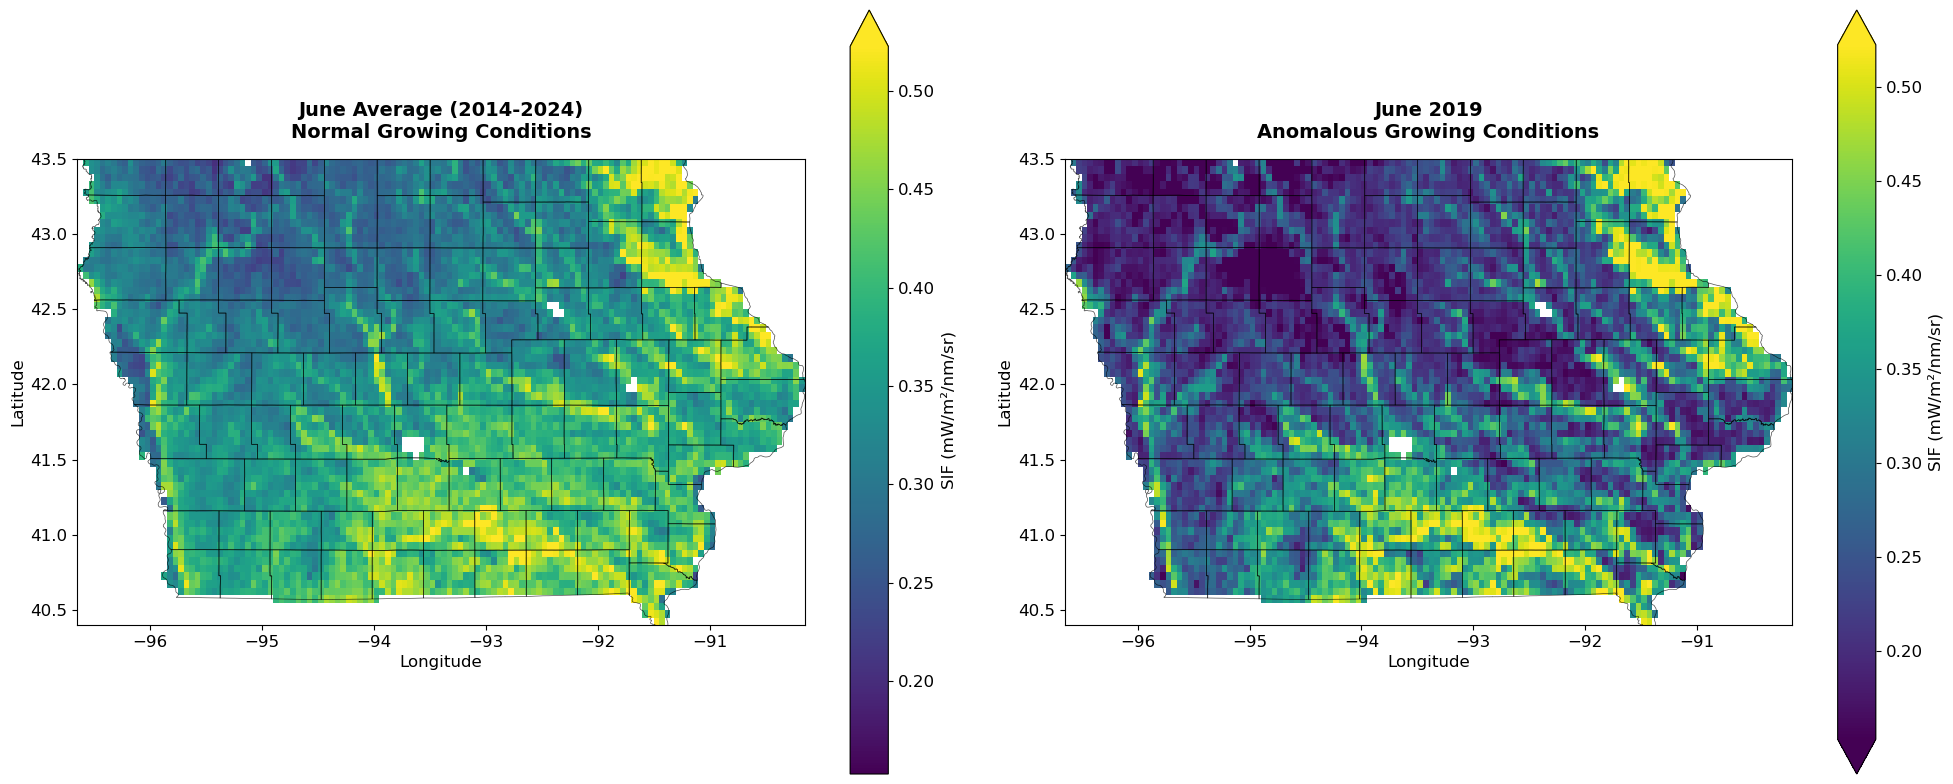


JUNE COMPARISON STATISTICS:
June average SIF: 0.3620 ± 0.0689
June 2019 SIF: 0.2818 ± 0.1017
Difference: -0.0802


In [22]:
print("=" * 60)
print("JUNE COMPARISON: AVERAGE vs 2019 ANOMALY")
print("=" * 60)

# Load June data for all years to calculate average
print("Loading June data for all years...")
june_data_all_years = []

for year in range(2014, 2025):
    june_sif = load_sif_for_month(year, 6)
    if june_sif is not None:
        june_data_all_years.append(june_sif)
        print(f"  ✓ Loaded June {year}")

if len(june_data_all_years) == 0:
    print("❌ No June data found!")
else:
    print(f"✓ Loaded {len(june_data_all_years)} years of June data")
    
    # Calculate June average across all years
    june_average = sum(june_data_all_years) / len(june_data_all_years)
    print("✓ Calculated June average across all years")
    
    # Load June 2019 specifically
    june_2019 = load_sif_for_month(2019, 6)
    
    if june_2019 is not None:
        print("✓ Loaded June 2019 data")
        
        # Create side-by-side comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Determine color scale limits (use same scale for both maps)
        all_values = np.concatenate([june_average.values.flatten(), june_2019.values.flatten()])
        vmin = np.nanpercentile(all_values, 2)  # 2nd percentile
        vmax = np.nanpercentile(all_values, 98)  # 98th percentile
        
        # Plot June average
        im1 = june_average.plot(ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax, 
                               add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
        ax1.set_title('June Average (2014-2024)\nNormal Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        
        # Plot June 2019
        im2 = june_2019.plot(ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax, 
                            add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
        ax2.set_title('June 2019\nAnomalous Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        
        plt.tight_layout()
        
        # Save the comparison
        output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/june_comparison_spatial.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ June comparison saved to: {output_path}")
        
        plt.show()
        
        # Calculate and print statistics
        print()
        print("JUNE COMPARISON STATISTICS:")
        print("=" * 40)
        print(f"June average SIF: {june_average.mean().values:.4f} ± {june_average.std().values:.4f}")
        print(f"June 2019 SIF: {june_2019.mean().values:.4f} ± {june_2019.std().values:.4f}")
        print(f"Difference: {june_2019.mean().values - june_average.mean().values:.4f}")
        
    else:
        print("❌ Could not load June 2019 data")


In [ ]:
print("=" * 60)
print("SEPTEMBER COMPARISON: AVERAGE vs 2020 vs 2023 ANOMALIES")
print("=" * 60)

# Load September data for all years to calculate average
print("Loading September data for all years...")
september_data_all_years = []

for year in range(2014, 2025):
    sep_sif = load_sif_for_month(year, 9)
    if sep_sif is not None:
        september_data_all_years.append(sep_sif)
        print(f"  ✓ Loaded September {year}")

if len(september_data_all_years) == 0:
    print("❌ No September data found!")
else:
    print(f"✓ Loaded {len(september_data_all_years)} years of September data")
    
    # Calculate September average across all years
    september_average = sum(september_data_all_years) / len(september_data_all_years)
    print("✓ Calculated September average across all years")
    
    # Load September 2020 and 2023
    september_2020 = load_sif_for_month(2020, 9)
    september_2023 = load_sif_for_month(2023, 9)
    
    if september_2020 is not None and september_2023 is not None:
        print("✓ Loaded September 2020 and 2023 data")
        
        # Create three-panel comparison
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
        
        # Determine color scale limits (use same scale for all three maps)
        all_values = np.concatenate([
            september_average.values.flatten(), 
            september_2020.values.flatten(),
            september_2023.values.flatten()
        ])
        vmin = np.nanpercentile(all_values, 2)  # 2nd percentile
        vmax = np.nanpercentile(all_values, 98)  # 98th percentile
        
        # Plot September average
        im1 = september_average.plot(ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax, 
                                   add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
        ax1.set_title('September Average (2014-2024)\nNormal Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        
        # Plot September 2020
        im2 = september_2020.plot(ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax, 
                                 add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
        ax2.set_title('September 2020\nAnomalous Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        
        # Plot September 2023
        im3 = september_2023.plot(ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax, 
                                 add_colorbar=True, cbar_kwargs={'label': 'SIF (mW/m²/nm/sr)'})
        iowa_counties.boundary.plot(ax=ax3, color='black', linewidth=0.5, alpha=0.7)
        ax3.set_title('September 2023\nAnomalous Growing Conditions', 
                     fontsize=14, fontweight='bold', pad=15)
        ax3.set_xlabel('Longitude', fontsize=12)
        ax3.set_ylabel('Latitude', fontsize=12)
        
        plt.tight_layout()
        
        # Save the comparison
        output_path = "/Users/jacksoncoldiron/Documents/Bren/Research/SIF/figures/september_comparison_spatial.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ September comparison saved to: {output_path}")
        
        plt.show()
        
        # Calculate and print statistics
        print()
        print("SEPTEMBER COMPARISON STATISTICS:")
        print("=" * 50)
        print(f"September average SIF: {september_average.mean().values:.4f} ± {september_average.std().values:.4f}")
        print(f"September 2020 SIF: {september_2020.mean().values:.4f} ± {september_2020.std().values:.4f}")
        print(f"September 2023 SIF: {september_2023.mean().values:.4f} ± {september_2023.std().values:.4f}")
        print()
        print("Differences from average:")
        print(f"  2020: {september_2020.mean().values - september_average.mean().values:.4f}")
        print(f"  2023: {september_2023.mean().values - september_average.mean().values:.4f}")
        
    else:
        print("❌ Could not load September 2020 or 2023 data")
